In [19]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [20]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [21]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

In [22]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [23]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,77.474,79.823,77.083,79.431,40.364,168059342623.000,2330.TW,70.823,82.561,...,77.777,80.228,79.952,2.537,1.571,81.099,73.014,64.929,0,1
1,2000-02-01,80.214,80.214,78.648,79.040,40.166,153081850577.000,2330.TW,70.823,82.561,...,73.809,76.819,78.908,2.585,1.773,81.819,73.484,65.148,0,1
2,2000-02-02,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,71.214,82.561,...,70.270,74.201,77.339,2.592,1.937,82.478,73.875,65.272,0,1
3,2000-02-03,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,73.171,82.561,...,76.470,70.301,74.993,2.569,2.064,82.999,74.344,65.690,0,1
4,2000-02-04,79.040,79.040,79.040,79.040,40.166,0.000,2330.TW,74.344,82.561,...,76.470,65.915,71.967,2.521,2.155,83.229,74.912,66.595,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5748,2023-02-14,544.000,546.000,543.000,545.000,545.000,21883297.000,2330.TW,522.000,546.000,...,66.154,87.914,84.696,18.869,17.559,569.301,517.075,464.849,0,1
5749,2023-02-15,526.000,532.000,522.000,525.000,525.000,61796793.000,2330.TW,522.000,546.000,...,41.818,62.776,77.390,16.978,17.443,565.229,520.400,475.571,1,0
5750,2023-02-16,528.000,531.000,524.000,528.000,528.000,29975138.000,2330.TW,522.000,546.000,...,53.261,50.184,68.321,15.542,17.063,563.843,522.750,481.657,0,1
5751,2023-02-17,524.000,524.000,516.000,518.000,518.000,28121975.000,2330.TW,516.000,546.000,...,43.617,35.678,57.440,13.442,16.339,561.937,524.350,486.763,0,1


# 查找DF的標籤

In [24]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4992

In [25]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5725

In [26]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4992,2020-01-02,332.500,339.000,332.500,339.000,316.967,31754120.000,2330.TW,328.500,339.000,...,52.830,56.781,49.078,6.590,7.294,350.319,330.400,310.481,1,0
4993,2020-01-03,344.000,345.000,335.500,339.500,317.434,41811268.000,2330.TW,329.500,345.000,...,43.820,59.359,52.505,6.601,7.156,350.161,331.775,313.389,1,0
4994,2020-01-06,333.000,334.500,332.000,332.000,310.422,45343057.000,2330.TW,331.000,345.000,...,37.864,41.954,48.988,5.937,6.912,348.971,332.725,316.479,1,0
4995,2020-01-07,332.500,333.000,326.500,329.500,308.084,50879181.000,2330.TW,326.500,345.000,...,43.820,33.375,43.783,5.149,6.559,347.831,333.400,318.969,1,0
4996,2020-01-08,325.000,333.000,325.000,329.500,308.084,37567748.000,2330.TW,325.000,345.000,...,50.649,29.750,39.106,4.473,6.142,345.582,334.200,322.818,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,2022-12-26,454.000,457.000,453.500,456.500,456.500,8793306.000,2330.TW,453.500,481.500,...,40.260,15.713,19.788,-0.244,4.264,499.698,475.200,450.702,0,1
5722,2022-12-27,458.000,462.500,457.000,457.000,457.000,10264001.000,2330.TW,453.500,481.500,...,31.852,14.642,18.073,-0.972,3.217,498.791,473.700,448.609,0,1
5723,2022-12-28,451.000,452.000,446.000,451.000,451.000,32578949.000,2330.TW,446.000,471.000,...,32.090,16.428,17.524,-2.009,2.172,497.523,471.750,445.977,1,0
5724,2022-12-29,444.000,449.500,442.500,446.000,446.000,23020759.000,2330.TW,442.500,469.500,...,31.387,15.273,16.774,-3.198,1.098,494.149,469.125,444.101,0,1


In [29]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['Volume_lower', 'Volume_greater']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [30]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | 2.16e-05 |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 0.69     |
| total_timesteps    | 5        |
| value_loss         | 3.53e+08 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 368       |
| nupdates           | 100       |
| policy_entropy     | 0.693     |
| total_timesteps    | 500       |
| value_loss         | 1.89e+08  |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 424      |
| nupdates           | 200      |
| policy_entropy     | 0.69     |
| total_timesteps    | 1000     |
| value_loss         | 2.45e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 446      |
| nupdates           | 300      |
| pol

---------------------------------
| explained_variance | 0        |
| fps                | 474      |
| nupdates           | 3000     |
| policy_entropy     | 0.00837  |
| total_timesteps    | 15000    |
| value_loss         | 5.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 473      |
| nupdates           | 3100     |
| policy_entropy     | 0.0161   |
| total_timesteps    | 15500    |
| value_loss         | 1.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 471      |
| nupdates           | 3200     |
| policy_entropy     | 0.0137   |
| total_timesteps    | 16000    |
| value_loss         | 3.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 469      |
| nupdates           | 3300     |
| policy_entropy     | 0.0134   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 477      |
| nupdates           | 6000     |
| policy_entropy     | 0.304    |
| total_timesteps    | 30000    |
| value_loss         | 1.68e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 477      |
| nupdates           | 6100     |
| policy_entropy     | 0.563    |
| total_timesteps    | 30500    |
| value_loss         | 1.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 476      |
| nupdates           | 6200     |
| policy_entropy     | 0.663    |
| total_timesteps    | 31000    |
| value_loss         | 2.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 476      |
| nupdates           | 6300     |
| policy_entropy     | 0.608    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 473      |
| nupdates           | 9000     |
| policy_entropy     | 0.0394   |
| total_timesteps    | 45000    |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 473      |
| nupdates           | 9100     |
| policy_entropy     | 0.0346   |
| total_timesteps    | 45500    |
| value_loss         | 9.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 473      |
| nupdates           | 9200     |
| policy_entropy     | 0.042    |
| total_timesteps    | 46000    |
| value_loss         | 9.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 473      |
| nupdates           | 9300     |
| policy_entropy     | 0.0225   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 473       |
| nupdates           | 12000     |
| policy_entropy     | 0.0893    |
| total_timesteps    | 60000     |
| value_loss         | 8.66e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 473      |
| nupdates           | 12100    |
| policy_entropy     | 0.57     |
| total_timesteps    | 60500    |
| value_loss         | 3e+08    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 473      |
| nupdates           | 12200    |
| policy_entropy     | 0.45     |
| total_timesteps    | 61000    |
| value_loss         | 2.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 474      |
| nupdates           | 12300    |
| policy_entropy     | 0.306    |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 482      |
| nupdates           | 15000    |
| policy_entropy     | 0.187    |
| total_timesteps    | 75000    |
| value_loss         | 1.5e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 482      |
| nupdates           | 15100    |
| policy_entropy     | 0.44     |
| total_timesteps    | 75500    |
| value_loss         | 1.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 483      |
| nupdates           | 15200    |
| policy_entropy     | 0.195    |
| total_timesteps    | 76000    |
| value_loss         | 8.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 483      |
| nupdates           | 15300    |
| policy_entropy     | 0.159    |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 482      |
| nupdates           | 18000    |
| policy_entropy     | 0.111    |
| total_timesteps    | 90000    |
| value_loss         | 1.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 482      |
| nupdates           | 18100    |
| policy_entropy     | 0.0865   |
| total_timesteps    | 90500    |
| value_loss         | 7.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 481      |
| nupdates           | 18200    |
| policy_entropy     | 0.266    |
| total_timesteps    | 91000    |
| value_loss         | 1.12e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 480       |
| nupdates           | 18300     |
| policy_entropy     | 0.0937    |
| total_t

---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 477      |
| nupdates           | 21000    |
| policy_entropy     | 0.0321   |
| total_timesteps    | 105000   |
| value_loss         | 1.78e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 477       |
| nupdates           | 21100     |
| policy_entropy     | 0.228     |
| total_timesteps    | 105500    |
| value_loss         | 1.22e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 478       |
| nupdates           | 21200     |
| policy_entropy     | 0.501     |
| total_timesteps    | 106000    |
| value_loss         | 1.59e+08  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 478       |
| nupdates           | 21300     |
| policy_entropy     | 0.021

----------------------------------
| explained_variance | -0.000371 |
| fps                | 475       |
| nupdates           | 24000     |
| policy_entropy     | 0.0836    |
| total_timesteps    | 120000    |
| value_loss         | 4.56e+07  |
----------------------------------
---------------------------------
| explained_variance | 8.43e-05 |
| fps                | 475      |
| nupdates           | 24100    |
| policy_entropy     | 0.117    |
| total_timesteps    | 120500   |
| value_loss         | 6.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 476      |
| nupdates           | 24200    |
| policy_entropy     | 0.0488   |
| total_timesteps    | 121000   |
| value_loss         | 1.58e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 476       |
| nupdates           | 24300     |
| policy_entropy     | 0.0238    |
|

---------------------------------
| explained_variance | 0.00122  |
| fps                | 472      |
| nupdates           | 27000    |
| policy_entropy     | 0.104    |
| total_timesteps    | 135000   |
| value_loss         | 3.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 472      |
| nupdates           | 27100    |
| policy_entropy     | 0.124    |
| total_timesteps    | 135500   |
| value_loss         | 7.84e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0561  |
| fps                | 472      |
| nupdates           | 27200    |
| policy_entropy     | 0.123    |
| total_timesteps    | 136000   |
| value_loss         | 5.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 472      |
| nupdates           | 27300    |
| policy_entropy     | 0.225    |
| total_timest

----------------------------------
| explained_variance | -0.000886 |
| fps                | 477       |
| nupdates           | 30000     |
| policy_entropy     | 0.0422    |
| total_timesteps    | 150000    |
| value_loss         | 1.28e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 477      |
| nupdates           | 30100    |
| policy_entropy     | 0.172    |
| total_timesteps    | 150500   |
| value_loss         | 7.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.134    |
| fps                | 477      |
| nupdates           | 30200    |
| policy_entropy     | 0.0642   |
| total_timesteps    | 151000   |
| value_loss         | 7.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 477      |
| nupdates           | 30300    |
| policy_entropy     | 0.244    |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 479      |
| nupdates           | 33100    |
| policy_entropy     | 0.175    |
| total_timesteps    | 165500   |
| value_loss         | 1.66e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 479       |
| nupdates           | 33200     |
| policy_entropy     | 0.229     |
| total_timesteps    | 166000    |
| value_loss         | 4.36e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 479       |
| nupdates           | 33300     |
| policy_entropy     | 0.268     |
| total_timesteps    | 166500    |
| value_loss         | 3.19e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 479      |
| nupdates           | 33400    |
| policy_entropy     | 0.177    

---------------------------------
| explained_variance | 0.0107   |
| fps                | 481      |
| nupdates           | 36100    |
| policy_entropy     | 0.0926   |
| total_timesteps    | 180500   |
| value_loss         | 4.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 481      |
| nupdates           | 36200    |
| policy_entropy     | 0.24     |
| total_timesteps    | 181000   |
| value_loss         | 5.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 481      |
| nupdates           | 36300    |
| policy_entropy     | 0.243    |
| total_timesteps    | 181500   |
| value_loss         | 1.03e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 481       |
| nupdates           | 36400     |
| policy_entropy     | 0.116     |
| total_t

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 485       |
| nupdates           | 39200     |
| policy_entropy     | 0.189     |
| total_timesteps    | 196000    |
| value_loss         | 1.7e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 485      |
| nupdates           | 39300    |
| policy_entropy     | 0.085    |
| total_timesteps    | 196500   |
| value_loss         | 2.11e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 485       |
| nupdates           | 39400     |
| policy_entropy     | 0.136     |
| total_timesteps    | 197000    |
| value_loss         | 9.32e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.148    |
| fps                | 486      |
| nupdates           | 39500    |
| policy_entropy     | 0.0102   

---------------------------------
| explained_variance | 0        |
| fps                | 485      |
| nupdates           | 42200    |
| policy_entropy     | 0.0677   |
| total_timesteps    | 211000   |
| value_loss         | 2.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 485      |
| nupdates           | 42300    |
| policy_entropy     | 0.0258   |
| total_timesteps    | 211500   |
| value_loss         | 1.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 485      |
| nupdates           | 42400    |
| policy_entropy     | 0.00721  |
| total_timesteps    | 212000   |
| value_loss         | 1.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0431   |
| fps                | 485      |
| nupdates           | 42500    |
| policy_entropy     | 0.00995  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 487      |
| nupdates           | 45200    |
| policy_entropy     | 0.0146   |
| total_timesteps    | 226000   |
| value_loss         | 4.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 487      |
| nupdates           | 45300    |
| policy_entropy     | 0.12     |
| total_timesteps    | 226500   |
| value_loss         | 1.3e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.31e-05 |
| fps                | 487       |
| nupdates           | 45400     |
| policy_entropy     | 0.0407    |
| total_timesteps    | 227000    |
| value_loss         | 5.19e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 487      |
| nupdates           | 45500    |
| policy_entropy     | 0.0929   |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 489      |
| nupdates           | 48200    |
| policy_entropy     | 0.0233   |
| total_timesteps    | 241000   |
| value_loss         | 8.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 489      |
| nupdates           | 48300    |
| policy_entropy     | 0.146    |
| total_timesteps    | 241500   |
| value_loss         | 1.87e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 489       |
| nupdates           | 48400     |
| policy_entropy     | 0.0254    |
| total_timesteps    | 242000    |
| value_loss         | 3.65e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 489      |
| nupdates           | 48500    |
| policy_entropy     | 0.111    |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 491       |
| nupdates           | 51200     |
| policy_entropy     | 0.107     |
| total_timesteps    | 256000    |
| value_loss         | 1.57e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 491      |
| nupdates           | 51300    |
| policy_entropy     | 0.115    |
| total_timesteps    | 256500   |
| value_loss         | 2.86e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 491       |
| nupdates           | 51400     |
| policy_entropy     | 0.00726   |
| total_timesteps    | 257000    |
| value_loss         | 2.2e+07   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 491      |
| nupdates           | 51500    |
| policy_entropy     | 0.0305   

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 493       |
| nupdates           | 54200     |
| policy_entropy     | 0.00732   |
| total_timesteps    | 271000    |
| value_loss         | 2.39e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 493       |
| nupdates           | 54300     |
| policy_entropy     | 0.00243   |
| total_timesteps    | 271500    |
| value_loss         | 2.22e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 493      |
| nupdates           | 54400    |
| policy_entropy     | 0.0266   |
| total_timesteps    | 272000   |
| value_loss         | 4.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 493      |
| nupdates           | 54500    |
| policy_entropy     | 0.0131   

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 494      |
| nupdates           | 57200    |
| policy_entropy     | 0.168    |
| total_timesteps    | 286000   |
| value_loss         | 9.54e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 494       |
| nupdates           | 57300     |
| policy_entropy     | 0.034     |
| total_timesteps    | 286500    |
| value_loss         | 1.61e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 494      |
| nupdates           | 57400    |
| policy_entropy     | 0.0153   |
| total_timesteps    | 287000   |
| value_loss         | 2.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 494      |
| nupdates           | 57500    |
| policy_entropy     | 0.0191   |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 495       |
| nupdates           | 60200     |
| policy_entropy     | 0.00328   |
| total_timesteps    | 301000    |
| value_loss         | 5.29e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 495      |
| nupdates           | 60300    |
| policy_entropy     | 0.0167   |
| total_timesteps    | 301500   |
| value_loss         | 3.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 495      |
| nupdates           | 60400    |
| policy_entropy     | 0.0105   |
| total_timesteps    | 302000   |
| value_loss         | 5.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 495      |
| nupdates           | 60500    |
| policy_entropy     | 0.146    |
| tota

---------------------------------
| explained_variance | 0.568    |
| fps                | 498      |
| nupdates           | 63200    |
| policy_entropy     | 0.0111   |
| total_timesteps    | 316000   |
| value_loss         | 1.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 498      |
| nupdates           | 63300    |
| policy_entropy     | 0.0688   |
| total_timesteps    | 316500   |
| value_loss         | 2.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 498      |
| nupdates           | 63400    |
| policy_entropy     | 0.0129   |
| total_timesteps    | 317000   |
| value_loss         | 1.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 498      |
| nupdates           | 63500    |
| policy_entropy     | 0.00654  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 499      |
| nupdates           | 66200    |
| policy_entropy     | 0.0037   |
| total_timesteps    | 331000   |
| value_loss         | 1.7e+09  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 499      |
| nupdates           | 66300    |
| policy_entropy     | 0.148    |
| total_timesteps    | 331500   |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 499      |
| nupdates           | 66400    |
| policy_entropy     | 0.0184   |
| total_timesteps    | 332000   |
| value_loss         | 1.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 500      |
| nupdates           | 66500    |
| policy_entropy     | 0.154    |
| total_timest

---------------------------------
| explained_variance | 0.15     |
| fps                | 500      |
| nupdates           | 69200    |
| policy_entropy     | 0.00107  |
| total_timesteps    | 346000   |
| value_loss         | 3.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.161    |
| fps                | 501      |
| nupdates           | 69300    |
| policy_entropy     | 0.0491   |
| total_timesteps    | 346500   |
| value_loss         | 3.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 501      |
| nupdates           | 69400    |
| policy_entropy     | 0.000702 |
| total_timesteps    | 347000   |
| value_loss         | 5.33e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 501       |
| nupdates           | 69500     |
| policy_entropy     | 0.00165   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 501      |
| nupdates           | 72200    |
| policy_entropy     | 0.0152   |
| total_timesteps    | 361000   |
| value_loss         | 6.13e+08 |
---------------------------------
----------------------------------
| explained_variance | -0.000323 |
| fps                | 501       |
| nupdates           | 72300     |
| policy_entropy     | 0.00018   |
| total_timesteps    | 361500    |
| value_loss         | 8.9e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.0741   |
| fps                | 501      |
| nupdates           | 72400    |
| policy_entropy     | 0.219    |
| total_timesteps    | 362000   |
| value_loss         | 1.52e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 501      |
| nupdates           | 72500    |
| policy_entropy     | 0.01     |
| tota

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 501      |
| nupdates           | 75200    |
| policy_entropy     | 9.04e-05 |
| total_timesteps    | 376000   |
| value_loss         | 2.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 501      |
| nupdates           | 75300    |
| policy_entropy     | 0.000166 |
| total_timesteps    | 376500   |
| value_loss         | 6.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 501      |
| nupdates           | 75400    |
| policy_entropy     | 0.000804 |
| total_timesteps    | 377000   |
| value_loss         | 1.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 501      |
| nupdates           | 75500    |
| policy_entropy     | 6.08e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 502      |
| nupdates           | 78200    |
| policy_entropy     | 0.0325   |
| total_timesteps    | 391000   |
| value_loss         | 6.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 502      |
| nupdates           | 78300    |
| policy_entropy     | 8.26e-05 |
| total_timesteps    | 391500   |
| value_loss         | 4.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 502      |
| nupdates           | 78400    |
| policy_entropy     | 0.0121   |
| total_timesteps    | 392000   |
| value_loss         | 1.18e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 502       |
| nupdates           | 78500     |
| policy_entropy     | 4e-05     |
| total_t

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 503      |
| nupdates           | 81200    |
| policy_entropy     | 0.0358   |
| total_timesteps    | 406000   |
| value_loss         | 6.11e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.347   |
| fps                | 503      |
| nupdates           | 81300    |
| policy_entropy     | 2.5e-05  |
| total_timesteps    | 406500   |
| value_loss         | 5.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 503      |
| nupdates           | 81400    |
| policy_entropy     | 0.00103  |
| total_timesteps    | 407000   |
| value_loss         | 7.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.707    |
| fps                | 503      |
| nupdates           | 81500    |
| policy_entropy     | 2.32e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 504      |
| nupdates           | 84300    |
| policy_entropy     | 0.0011   |
| total_timesteps    | 421500   |
| value_loss         | 9.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 504      |
| nupdates           | 84400    |
| policy_entropy     | 0.000146 |
| total_timesteps    | 422000   |
| value_loss         | 3.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 504      |
| nupdates           | 84500    |
| policy_entropy     | 4.97e-05 |
| total_timesteps    | 422500   |
| value_loss         | 8.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 504      |
| nupdates           | 84600    |
| policy_entropy     | 0.000144 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 87400    |
| policy_entropy     | 0.00782  |
| total_timesteps    | 437000   |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.565   |
| fps                | 505      |
| nupdates           | 87500    |
| policy_entropy     | 0.000116 |
| total_timesteps    | 437500   |
| value_loss         | 1.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 87600    |
| policy_entropy     | 0.139    |
| total_timesteps    | 438000   |
| value_loss         | 1.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 87700    |
| policy_entropy     | 0.000847 |
| total_timest

---------------------------------
| explained_variance | 0.231    |
| fps                | 505      |
| nupdates           | 90500    |
| policy_entropy     | 0.000356 |
| total_timesteps    | 452500   |
| value_loss         | 6.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.587    |
| fps                | 505      |
| nupdates           | 90600    |
| policy_entropy     | 0.0835   |
| total_timesteps    | 453000   |
| value_loss         | 7.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 90700    |
| policy_entropy     | 0.000207 |
| total_timesteps    | 453500   |
| value_loss         | 1.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 90800    |
| policy_entropy     | 8.48e-05 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 504       |
| nupdates           | 93600     |
| policy_entropy     | 0.00592   |
| total_timesteps    | 468000    |
| value_loss         | 6.01e+07  |
----------------------------------
---------------------------------
| explained_variance | -0.735   |
| fps                | 504      |
| nupdates           | 93700    |
| policy_entropy     | 0.136    |
| total_timesteps    | 468500   |
| value_loss         | 1.1e+08  |
---------------------------------
---------------------------------
| explained_variance | 4.02e-05 |
| fps                | 504      |
| nupdates           | 93800    |
| policy_entropy     | 0.00564  |
| total_timesteps    | 469000   |
| value_loss         | 1.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 504      |
| nupdates           | 93900    |
| policy_entropy     | 0.000374 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 504       |
| nupdates           | 96700     |
| policy_entropy     | 3.18e-05  |
| total_timesteps    | 483500    |
| value_loss         | 2.65e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 504      |
| nupdates           | 96800    |
| policy_entropy     | 0.203    |
| total_timesteps    | 484000   |
| value_loss         | 4.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.363    |
| fps                | 504      |
| nupdates           | 96900    |
| policy_entropy     | 0.0175   |
| total_timesteps    | 484500   |
| value_loss         | 2.23e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 504       |
| nupdates           | 97000     |
| policy_entropy     | 0.0774    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 503      |
| nupdates           | 99800    |
| policy_entropy     | 0.00426  |
| total_timesteps    | 499000   |
| value_loss         | 4.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.76     |
| fps                | 503      |
| nupdates           | 99900    |
| policy_entropy     | 0.000203 |
| total_timesteps    | 499500   |
| value_loss         | 1.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.529    |
| fps                | 503      |
| nupdates           | 100000   |
| policy_entropy     | 0.11     |
| total_timesteps    | 500000   |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 503      |
| nupdates           | 100100   |
| policy_entropy     | 0.000313 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 504       |
| nupdates           | 102900    |
| policy_entropy     | 0.0293    |
| total_timesteps    | 514500    |
| value_loss         | 2.18e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.225    |
| fps                | 504      |
| nupdates           | 103000   |
| policy_entropy     | 0.0138   |
| total_timesteps    | 515000   |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 504      |
| nupdates           | 103100   |
| policy_entropy     | 0.0364   |
| total_timesteps    | 515500   |
| value_loss         | 1.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 504      |
| nupdates           | 103200   |
| policy_entropy     | 0.0547   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 504      |
| nupdates           | 106000   |
| policy_entropy     | 0.0221   |
| total_timesteps    | 530000   |
| value_loss         | 4.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 504      |
| nupdates           | 106100   |
| policy_entropy     | 0.00835  |
| total_timesteps    | 530500   |
| value_loss         | 3.63e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0507  |
| fps                | 504      |
| nupdates           | 106200   |
| policy_entropy     | 2.31e-05 |
| total_timesteps    | 531000   |
| value_loss         | 2.87e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.53    |
| fps                | 504      |
| nupdates           | 106300   |
| policy_entropy     | 0.132    |
| total_timest

---------------------------------
| explained_variance | 0.0336   |
| fps                | 505      |
| nupdates           | 109100   |
| policy_entropy     | 0.0592   |
| total_timesteps    | 545500   |
| value_loss         | 1.63e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.587    |
| fps                | 505      |
| nupdates           | 109200   |
| policy_entropy     | 0.0153   |
| total_timesteps    | 546000   |
| value_loss         | 5.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.234    |
| fps                | 505      |
| nupdates           | 109300   |
| policy_entropy     | 6.86e-05 |
| total_timesteps    | 546500   |
| value_loss         | 7.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 109400   |
| policy_entropy     | 0.29     |
| total_timest

---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 505      |
| nupdates           | 112100   |
| policy_entropy     | 0.000144 |
| total_timesteps    | 560500   |
| value_loss         | 1.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.24     |
| fps                | 505      |
| nupdates           | 112200   |
| policy_entropy     | 0.000718 |
| total_timesteps    | 561000   |
| value_loss         | 6.13e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 505       |
| nupdates           | 112300    |
| policy_entropy     | 0.0879    |
| total_timesteps    | 561500    |
| value_loss         | 1.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.117    |
| fps                | 505      |
| nupdates           | 112400   |
| policy_entropy     | 0.00288  |
| tota

---------------------------------
| explained_variance | 0.361    |
| fps                | 506      |
| nupdates           | 115100   |
| policy_entropy     | 0.00278  |
| total_timesteps    | 575500   |
| value_loss         | 2.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 115200   |
| policy_entropy     | 0.000305 |
| total_timesteps    | 576000   |
| value_loss         | 1.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 115300   |
| policy_entropy     | 0.0273   |
| total_timesteps    | 576500   |
| value_loss         | 4.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 506      |
| nupdates           | 115400   |
| policy_entropy     | 6.89e-05 |
| total_timest

---------------------------------
| explained_variance | 0.149    |
| fps                | 507      |
| nupdates           | 118100   |
| policy_entropy     | 0.032    |
| total_timesteps    | 590500   |
| value_loss         | 3.38e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.86    |
| fps                | 507      |
| nupdates           | 118200   |
| policy_entropy     | 0.00358  |
| total_timesteps    | 591000   |
| value_loss         | 8.34e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0444  |
| fps                | 507      |
| nupdates           | 118300   |
| policy_entropy     | 0.316    |
| total_timesteps    | 591500   |
| value_loss         | 1.86e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.366   |
| fps                | 507      |
| nupdates           | 118400   |
| policy_entropy     | 0.0498   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 121200   |
| policy_entropy     | 0.0483   |
| total_timesteps    | 606000   |
| value_loss         | 5.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 507      |
| nupdates           | 121300   |
| policy_entropy     | 0.00311  |
| total_timesteps    | 606500   |
| value_loss         | 1.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.193    |
| fps                | 508      |
| nupdates           | 121400   |
| policy_entropy     | 0.14     |
| total_timesteps    | 607000   |
| value_loss         | 6.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 121500   |
| policy_entropy     | 0.0879   |
| total_timest

---------------------------------
| explained_variance | 0.0249   |
| fps                | 508      |
| nupdates           | 124300   |
| policy_entropy     | 0.152    |
| total_timesteps    | 621500   |
| value_loss         | 2.55e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 508      |
| nupdates           | 124400   |
| policy_entropy     | 0.12     |
| total_timesteps    | 622000   |
| value_loss         | 1.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000345 |
| fps                | 508      |
| nupdates           | 124500   |
| policy_entropy     | 0.057    |
| total_timesteps    | 622500   |
| value_loss         | 5.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.219    |
| fps                | 508      |
| nupdates           | 124600   |
| policy_entropy     | 0.00685  |
| total_timest

---------------------------------
| explained_variance | 0.11     |
| fps                | 508      |
| nupdates           | 127400   |
| policy_entropy     | 0.0335   |
| total_timesteps    | 637000   |
| value_loss         | 1.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000486 |
| fps                | 508      |
| nupdates           | 127500   |
| policy_entropy     | 0.00737  |
| total_timesteps    | 637500   |
| value_loss         | 4.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.547    |
| fps                | 508      |
| nupdates           | 127600   |
| policy_entropy     | 0.0565   |
| total_timesteps    | 638000   |
| value_loss         | 1.25e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.226   |
| fps                | 508      |
| nupdates           | 127700   |
| policy_entropy     | 0.136    |
| total_timest

---------------------------------
| explained_variance | 0.427    |
| fps                | 509      |
| nupdates           | 130500   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 652500   |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 509      |
| nupdates           | 130600   |
| policy_entropy     | 0.0524   |
| total_timesteps    | 653000   |
| value_loss         | 5.04e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.115   |
| fps                | 509      |
| nupdates           | 130700   |
| policy_entropy     | 0.112    |
| total_timesteps    | 653500   |
| value_loss         | 7.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0141   |
| fps                | 509      |
| nupdates           | 130800   |
| policy_entropy     | 0.231    |
| total_timest

---------------------------------
| explained_variance | 0.798    |
| fps                | 509      |
| nupdates           | 133600   |
| policy_entropy     | 6.37e-05 |
| total_timesteps    | 668000   |
| value_loss         | 1.59e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 509       |
| nupdates           | 133700    |
| policy_entropy     | 0.138     |
| total_timesteps    | 668500    |
| value_loss         | 3.65e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.6      |
| fps                | 509      |
| nupdates           | 133800   |
| policy_entropy     | 0.105    |
| total_timesteps    | 669000   |
| value_loss         | 7e+07    |
---------------------------------
---------------------------------
| explained_variance | 0.0174   |
| fps                | 509      |
| nupdates           | 133900   |
| policy_entropy     | 0.0723   |
| tota

---------------------------------
| explained_variance | 0.189    |
| fps                | 510      |
| nupdates           | 136600   |
| policy_entropy     | 0.223    |
| total_timesteps    | 683000   |
| value_loss         | 8.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 136700   |
| policy_entropy     | 1.67e-05 |
| total_timesteps    | 683500   |
| value_loss         | 2.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000423 |
| fps                | 510      |
| nupdates           | 136800   |
| policy_entropy     | 0.000386 |
| total_timesteps    | 684000   |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.451    |
| fps                | 510      |
| nupdates           | 136900   |
| policy_entropy     | 0.135    |
| total_timest

----------------------------------
| explained_variance | -0.000416 |
| fps                | 510       |
| nupdates           | 139700    |
| policy_entropy     | 0.132     |
| total_timesteps    | 698500    |
| value_loss         | 1.38e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.65     |
| fps                | 510      |
| nupdates           | 139800   |
| policy_entropy     | 0.012    |
| total_timesteps    | 699000   |
| value_loss         | 5.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.99e-05 |
| fps                | 510      |
| nupdates           | 139900   |
| policy_entropy     | 0.0222   |
| total_timesteps    | 699500   |
| value_loss         | 5.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 510      |
| nupdates           | 140000   |
| policy_entropy     | 3.71e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 510      |
| nupdates           | 142800   |
| policy_entropy     | 0.108    |
| total_timesteps    | 714000   |
| value_loss         | 3.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000639 |
| fps                | 510      |
| nupdates           | 142900   |
| policy_entropy     | 4.6e-05  |
| total_timesteps    | 714500   |
| value_loss         | 3.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.742    |
| fps                | 510      |
| nupdates           | 143000   |
| policy_entropy     | 0.108    |
| total_timesteps    | 715000   |
| value_loss         | 1.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 510      |
| nupdates           | 143100   |
| policy_entropy     | 0.00196  |
| total_timest

---------------------------------
| explained_variance | 0.254    |
| fps                | 509      |
| nupdates           | 145900   |
| policy_entropy     | 2.02e-05 |
| total_timesteps    | 729500   |
| value_loss         | 1.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.604    |
| fps                | 509      |
| nupdates           | 146000   |
| policy_entropy     | 2.36e-05 |
| total_timesteps    | 730000   |
| value_loss         | 2.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.383    |
| fps                | 509      |
| nupdates           | 146100   |
| policy_entropy     | 0.137    |
| total_timesteps    | 730500   |
| value_loss         | 6.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.658    |
| fps                | 509      |
| nupdates           | 146200   |
| policy_entropy     | 0.0676   |
| total_timest

---------------------------------
| explained_variance | 0.00581  |
| fps                | 509      |
| nupdates           | 148900   |
| policy_entropy     | 0.00067  |
| total_timesteps    | 744500   |
| value_loss         | 9.67e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 149000    |
| policy_entropy     | 0.000104  |
| total_timesteps    | 745000    |
| value_loss         | 1.02e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.425    |
| fps                | 509      |
| nupdates           | 149100   |
| policy_entropy     | 0.0318   |
| total_timesteps    | 745500   |
| value_loss         | 2.19e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 149200    |
| policy_entropy     | 1.43e-07  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 151900    |
| policy_entropy     | 0.0183    |
| total_timesteps    | 759500    |
| value_loss         | 1.52e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.32e-05 |
| fps                | 508      |
| nupdates           | 152000   |
| policy_entropy     | 7.13e-06 |
| total_timesteps    | 760000   |
| value_loss         | 4.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 508      |
| nupdates           | 152100   |
| policy_entropy     | 1.92e-06 |
| total_timesteps    | 760500   |
| value_loss         | 3.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.349    |
| fps                | 508      |
| nupdates           | 152200   |
| policy_entropy     | 0.000368 |
| tota

---------------------------------
| explained_variance | 0.449    |
| fps                | 508      |
| nupdates           | 155000   |
| policy_entropy     | 0.13     |
| total_timesteps    | 775000   |
| value_loss         | 1.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 155100   |
| policy_entropy     | 7.23e-05 |
| total_timesteps    | 775500   |
| value_loss         | 3.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.787    |
| fps                | 508      |
| nupdates           | 155200   |
| policy_entropy     | 0.000848 |
| total_timesteps    | 776000   |
| value_loss         | 6.52e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0083  |
| fps                | 508      |
| nupdates           | 155300   |
| policy_entropy     | 0.00412  |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 508      |
| nupdates           | 158000   |
| policy_entropy     | 4.33e-06 |
| total_timesteps    | 790000   |
| value_loss         | 1.43e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.253   |
| fps                | 508      |
| nupdates           | 158100   |
| policy_entropy     | 0.108    |
| total_timesteps    | 790500   |
| value_loss         | 9.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0453   |
| fps                | 508      |
| nupdates           | 158200   |
| policy_entropy     | 0.119    |
| total_timesteps    | 791000   |
| value_loss         | 1.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.33     |
| fps                | 508      |
| nupdates           | 158300   |
| policy_entropy     | 5.9e-06  |
| total_timest

---------------------------------
| explained_variance | 4.65e-06 |
| fps                | 508      |
| nupdates           | 161000   |
| policy_entropy     | 0.0746   |
| total_timesteps    | 805000   |
| value_loss         | 1.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.192    |
| fps                | 508      |
| nupdates           | 161100   |
| policy_entropy     | 0.0253   |
| total_timesteps    | 805500   |
| value_loss         | 5.6e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 161200   |
| policy_entropy     | 0.222    |
| total_timesteps    | 806000   |
| value_loss         | 2.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.425    |
| fps                | 508      |
| nupdates           | 161300   |
| policy_entropy     | 0.0018   |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 507      |
| nupdates           | 164000   |
| policy_entropy     | 8.93e-05 |
| total_timesteps    | 820000   |
| value_loss         | 3.41e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.87e-06 |
| fps                | 507       |
| nupdates           | 164100    |
| policy_entropy     | 0.0419    |
| total_timesteps    | 820500    |
| value_loss         | 1.39e+07  |
----------------------------------
----------------------------------
| explained_variance | -0.000144 |
| fps                | 507       |
| nupdates           | 164200    |
| policy_entropy     | 0.132     |
| total_timesteps    | 821000    |
| value_loss         | 4.26e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 164300    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 506      |
| nupdates           | 167000   |
| policy_entropy     | 0.00183  |
| total_timesteps    | 835000   |
| value_loss         | 3.23e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.5e-05 |
| fps                | 506      |
| nupdates           | 167100   |
| policy_entropy     | 0.14     |
| total_timesteps    | 835500   |
| value_loss         | 4.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.818    |
| fps                | 506      |
| nupdates           | 167200   |
| policy_entropy     | 0.0838   |
| total_timesteps    | 836000   |
| value_loss         | 1.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.201    |
| fps                | 506      |
| nupdates           | 167300   |
| policy_entropy     | 0.00427  |
| total_timest

----------------------------------
| explained_variance | -0.000241 |
| fps                | 506       |
| nupdates           | 170100    |
| policy_entropy     | 0.0473    |
| total_timesteps    | 850500    |
| value_loss         | 9.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.707    |
| fps                | 506      |
| nupdates           | 170200   |
| policy_entropy     | 0.0232   |
| total_timesteps    | 851000   |
| value_loss         | 5.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000125 |
| fps                | 506      |
| nupdates           | 170300   |
| policy_entropy     | 0.000959 |
| total_timesteps    | 851500   |
| value_loss         | 5.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.269    |
| fps                | 506      |
| nupdates           | 170400   |
| policy_entropy     | 0.216    |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 505      |
| nupdates           | 173100   |
| policy_entropy     | 0.0769   |
| total_timesteps    | 865500   |
| value_loss         | 2.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 173200   |
| policy_entropy     | 0.000281 |
| total_timesteps    | 866000   |
| value_loss         | 4.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.627    |
| fps                | 505      |
| nupdates           | 173300   |
| policy_entropy     | 0.0655   |
| total_timesteps    | 866500   |
| value_loss         | 1.37e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 505       |
| nupdates           | 173400    |
| policy_entropy     | 0.00557   |
| total_t

---------------------------------
| explained_variance | 0.293    |
| fps                | 505      |
| nupdates           | 176200   |
| policy_entropy     | 0.0693   |
| total_timesteps    | 881000   |
| value_loss         | 2.55e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.016   |
| fps                | 505      |
| nupdates           | 176300   |
| policy_entropy     | 0.00293  |
| total_timesteps    | 881500   |
| value_loss         | 1.7e+09  |
---------------------------------
---------------------------------
| explained_variance | 0.802    |
| fps                | 505      |
| nupdates           | 176400   |
| policy_entropy     | 0.0754   |
| total_timesteps    | 882000   |
| value_loss         | 2.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00141  |
| fps                | 505      |
| nupdates           | 176500   |
| policy_entropy     | 0.179    |
| total_timest

---------------------------------
| explained_variance | 0.482    |
| fps                | 505      |
| nupdates           | 179300   |
| policy_entropy     | 0.00062  |
| total_timesteps    | 896500   |
| value_loss         | 5e+07    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 179400   |
| policy_entropy     | 0.000107 |
| total_timesteps    | 897000   |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 505      |
| nupdates           | 179500   |
| policy_entropy     | 0.0456   |
| total_timesteps    | 897500   |
| value_loss         | 1.96e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 505       |
| nupdates           | 179600    |
| policy_entropy     | 0.00275   |
| total_t

---------------------------------
| explained_variance | -0.247   |
| fps                | 505      |
| nupdates           | 182300   |
| policy_entropy     | 0.00175  |
| total_timesteps    | 911500   |
| value_loss         | 1.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 504      |
| nupdates           | 182400   |
| policy_entropy     | 0.000779 |
| total_timesteps    | 912000   |
| value_loss         | 4.68e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 504      |
| nupdates           | 182500   |
| policy_entropy     | 3.13e-05 |
| total_timesteps    | 912500   |
| value_loss         | 1.78e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.205    |
| fps                | 504      |
| nupdates           | 182600   |
| policy_entropy     | 2.6e-05  |
| total_timest

---------------------------------
| explained_variance | 0.636    |
| fps                | 504      |
| nupdates           | 185400   |
| policy_entropy     | 0.000186 |
| total_timesteps    | 927000   |
| value_loss         | 4.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 504      |
| nupdates           | 185500   |
| policy_entropy     | 0.0604   |
| total_timesteps    | 927500   |
| value_loss         | 8.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000591 |
| fps                | 504      |
| nupdates           | 185600   |
| policy_entropy     | 0.0399   |
| total_timesteps    | 928000   |
| value_loss         | 9.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 504      |
| nupdates           | 185700   |
| policy_entropy     | 0.00105  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 504       |
| nupdates           | 188500    |
| policy_entropy     | 0.000189  |
| total_timesteps    | 942500    |
| value_loss         | 3.65e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 504      |
| nupdates           | 188600   |
| policy_entropy     | 0.128    |
| total_timesteps    | 943000   |
| value_loss         | 1.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00299  |
| fps                | 504      |
| nupdates           | 188700   |
| policy_entropy     | 2.52e-06 |
| total_timesteps    | 943500   |
| value_loss         | 4.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 504      |
| nupdates           | 188800   |
| policy_entropy     | 9.96e-05 |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 504       |
| nupdates           | 191600    |
| policy_entropy     | 0.00076   |
| total_timesteps    | 958000    |
| value_loss         | 6.93e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.37     |
| fps                | 504      |
| nupdates           | 191700   |
| policy_entropy     | 0.0337   |
| total_timesteps    | 958500   |
| value_loss         | 2.81e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 504       |
| nupdates           | 191800    |
| policy_entropy     | 0.00814   |
| total_timesteps    | 959000    |
| value_loss         | 4.29e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.0103   |
| fps                | 504      |
| nupdates           | 191900   |
| policy_entropy     | 0.000227 

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 504      |
| nupdates           | 194700   |
| policy_entropy     | 0.000268 |
| total_timesteps    | 973500   |
| value_loss         | 1.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 504      |
| nupdates           | 194800   |
| policy_entropy     | 0.172    |
| total_timesteps    | 974000   |
| value_loss         | 3.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0539   |
| fps                | 504      |
| nupdates           | 194900   |
| policy_entropy     | 0.00374  |
| total_timesteps    | 974500   |
| value_loss         | 9.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.432    |
| fps                | 504      |
| nupdates           | 195000   |
| policy_entropy     | 1.3e-06  |
| total_timest

---------------------------------
| explained_variance | 0.524    |
| fps                | 505      |
| nupdates           | 197800   |
| policy_entropy     | 0.0763   |
| total_timesteps    | 989000   |
| value_loss         | 5.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 505      |
| nupdates           | 197900   |
| policy_entropy     | 1.16e-05 |
| total_timesteps    | 989500   |
| value_loss         | 1.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.167    |
| fps                | 505      |
| nupdates           | 198000   |
| policy_entropy     | 0.0931   |
| total_timesteps    | 990000   |
| value_loss         | 9.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 505      |
| nupdates           | 198100   |
| policy_entropy     | 0.111    |
| total_timest

---------------------------------
| explained_variance | 0.000671 |
| fps                | 505      |
| nupdates           | 200900   |
| policy_entropy     | 0.000642 |
| total_timesteps    | 1004500  |
| value_loss         | 3.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 505      |
| nupdates           | 201000   |
| policy_entropy     | 0.0208   |
| total_timesteps    | 1005000  |
| value_loss         | 2.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.712    |
| fps                | 505      |
| nupdates           | 201100   |
| policy_entropy     | 0.000927 |
| total_timesteps    | 1005500  |
| value_loss         | 4.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.862    |
| fps                | 505      |
| nupdates           | 201200   |
| policy_entropy     | 0.103    |
| total_timest

---------------------------------
| explained_variance | 0.723    |
| fps                | 505      |
| nupdates           | 204000   |
| policy_entropy     | 0.0815   |
| total_timesteps    | 1020000  |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.114    |
| fps                | 505      |
| nupdates           | 204100   |
| policy_entropy     | 0.142    |
| total_timesteps    | 1020500  |
| value_loss         | 2.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.639    |
| fps                | 505      |
| nupdates           | 204200   |
| policy_entropy     | 0.0505   |
| total_timesteps    | 1021000  |
| value_loss         | 1.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.146    |
| fps                | 505      |
| nupdates           | 204300   |
| policy_entropy     | 0.102    |
| total_timest

---------------------------------
| explained_variance | 0.935    |
| fps                | 505      |
| nupdates           | 207100   |
| policy_entropy     | 0.0438   |
| total_timesteps    | 1035500  |
| value_loss         | 6.97e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 505       |
| nupdates           | 207200    |
| policy_entropy     | 0.000152  |
| total_timesteps    | 1036000   |
| value_loss         | 3.07e+08  |
----------------------------------
---------------------------------
| explained_variance | -3e-05   |
| fps                | 505      |
| nupdates           | 207300   |
| policy_entropy     | 0.00163  |
| total_timesteps    | 1036500  |
| value_loss         | 2.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.534    |
| fps                | 505      |
| nupdates           | 207400   |
| policy_entropy     | 3.28e-05 |
| tota

---------------------------------
| explained_variance | 0.279    |
| fps                | 505      |
| nupdates           | 210200   |
| policy_entropy     | 0.00964  |
| total_timesteps    | 1051000  |
| value_loss         | 5.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.782    |
| fps                | 505      |
| nupdates           | 210300   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 1051500  |
| value_loss         | 4.38e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000295 |
| fps                | 506      |
| nupdates           | 210400   |
| policy_entropy     | 0.0243   |
| total_timesteps    | 1052000  |
| value_loss         | 2.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 210500   |
| policy_entropy     | 0.00334  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 213300    |
| policy_entropy     | 0.000377  |
| total_timesteps    | 1066500   |
| value_loss         | 7.58e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.852    |
| fps                | 506      |
| nupdates           | 213400   |
| policy_entropy     | 0.000628 |
| total_timesteps    | 1067000  |
| value_loss         | 1.08e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 213500    |
| policy_entropy     | 1.28e-05  |
| total_timesteps    | 1067500   |
| value_loss         | 5.22e+08  |
----------------------------------
---------------------------------
| explained_variance | -0.464   |
| fps                | 506      |
| nupdates           | 213600   |
| policy_entropy     | 0.173    

---------------------------------
| explained_variance | 5.01e-05 |
| fps                | 506      |
| nupdates           | 216400   |
| policy_entropy     | 0.000128 |
| total_timesteps    | 1082000  |
| value_loss         | 1.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 216500   |
| policy_entropy     | 0.0129   |
| total_timesteps    | 1082500  |
| value_loss         | 2.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.874    |
| fps                | 506      |
| nupdates           | 216600   |
| policy_entropy     | 2.48e-05 |
| total_timesteps    | 1083000  |
| value_loss         | 7.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 506      |
| nupdates           | 216700   |
| policy_entropy     | 8.88e-07 |
| total_timest

---------------------------------
| explained_variance | 0.963    |
| fps                | 506      |
| nupdates           | 219500   |
| policy_entropy     | 5.49e-07 |
| total_timesteps    | 1097500  |
| value_loss         | 6.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.758    |
| fps                | 506      |
| nupdates           | 219600   |
| policy_entropy     | 0.00212  |
| total_timesteps    | 1098000  |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.722    |
| fps                | 506      |
| nupdates           | 219700   |
| policy_entropy     | 6.42e-05 |
| total_timesteps    | 1098500  |
| value_loss         | 4.04e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.81    |
| fps                | 506      |
| nupdates           | 219800   |
| policy_entropy     | 0.17     |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 222600   |
| policy_entropy     | 6.45e-09 |
| total_timesteps    | 1113000  |
| value_loss         | 4.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 506      |
| nupdates           | 222700   |
| policy_entropy     | 0.00105  |
| total_timesteps    | 1113500  |
| value_loss         | 9.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 506      |
| nupdates           | 222800   |
| policy_entropy     | 0.000403 |
| total_timesteps    | 1114000  |
| value_loss         | 3.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.624    |
| fps                | 506      |
| nupdates           | 222900   |
| policy_entropy     | 6.65e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0948   |
| fps                | 507      |
| nupdates           | 225700   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 1128500  |
| value_loss         | 1.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.582    |
| fps                | 507      |
| nupdates           | 225800   |
| policy_entropy     | 7.54e-05 |
| total_timesteps    | 1129000  |
| value_loss         | 1.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 507      |
| nupdates           | 225900   |
| policy_entropy     | 6.88e-05 |
| total_timesteps    | 1129500  |
| value_loss         | 2.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 226000   |
| policy_entropy     | 8.51e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 228800   |
| policy_entropy     | 0.0287   |
| total_timesteps    | 1144000  |
| value_loss         | 8.56e+06 |
---------------------------------
---------------------------------
| explained_variance | -2.15    |
| fps                | 507      |
| nupdates           | 228900   |
| policy_entropy     | 0.00605  |
| total_timesteps    | 1144500  |
| value_loss         | 1.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 229000   |
| policy_entropy     | 6.73e-05 |
| total_timesteps    | 1145000  |
| value_loss         | 4.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 507      |
| nupdates           | 229100   |
| policy_entropy     | 8.7e-05  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 507      |
| nupdates           | 231900   |
| policy_entropy     | 4.04e-08 |
| total_timesteps    | 1159500  |
| value_loss         | 1.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.435    |
| fps                | 507      |
| nupdates           | 232000   |
| policy_entropy     | 0.192    |
| total_timesteps    | 1160000  |
| value_loss         | 1.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 507      |
| nupdates           | 232100   |
| policy_entropy     | 0.0137   |
| total_timesteps    | 1160500  |
| value_loss         | 3.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.42     |
| fps                | 507      |
| nupdates           | 232200   |
| policy_entropy     | 2.87e-05 |
| total_timest

---------------------------------
| explained_variance | 0.927    |
| fps                | 507      |
| nupdates           | 235000   |
| policy_entropy     | 0.00163  |
| total_timesteps    | 1175000  |
| value_loss         | 4.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.371    |
| fps                | 507      |
| nupdates           | 235100   |
| policy_entropy     | 0.0201   |
| total_timesteps    | 1175500  |
| value_loss         | 5.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 235200   |
| policy_entropy     | 1.8e-05  |
| total_timesteps    | 1176000  |
| value_loss         | 2.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 507      |
| nupdates           | 235300   |
| policy_entropy     | 0.0143   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 238100   |
| policy_entropy     | 0.00165  |
| total_timesteps    | 1190500  |
| value_loss         | 5.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.247    |
| fps                | 508      |
| nupdates           | 238200   |
| policy_entropy     | 0.000293 |
| total_timesteps    | 1191000  |
| value_loss         | 3.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 238300   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 1191500  |
| value_loss         | 2.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.804    |
| fps                | 508      |
| nupdates           | 238400   |
| policy_entropy     | 0.0403   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 241200    |
| policy_entropy     | 4.3e-07   |
| total_timesteps    | 1206000   |
| value_loss         | 1.32e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 241300   |
| policy_entropy     | 0.000151 |
| total_timesteps    | 1206500  |
| value_loss         | 6.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.539    |
| fps                | 508      |
| nupdates           | 241400   |
| policy_entropy     | 0.000138 |
| total_timesteps    | 1207000  |
| value_loss         | 7.2e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 241500    |
| policy_entropy     | 1.37e-05  |
|

---------------------------------
| explained_variance | -0.166   |
| fps                | 508      |
| nupdates           | 244200   |
| policy_entropy     | 1.42e-08 |
| total_timesteps    | 1221000  |
| value_loss         | 1.03e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 244300    |
| policy_entropy     | 4.78e-06  |
| total_timesteps    | 1221500   |
| value_loss         | 6.68e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.28e-05 |
| fps                | 508       |
| nupdates           | 244400    |
| policy_entropy     | 0.02      |
| total_timesteps    | 1222000   |
| value_loss         | 2.5e+06   |
----------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 508      |
| nupdates           | 244500   |
| policy_entropy     | 0.00148  

---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 508      |
| nupdates           | 247300   |
| policy_entropy     | 0.00212  |
| total_timesteps    | 1236500  |
| value_loss         | 4.4e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.11e-05 |
| fps                | 508       |
| nupdates           | 247400    |
| policy_entropy     | 1.25e-08  |
| total_timesteps    | 1237000   |
| value_loss         | 4e+07     |
----------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 508      |
| nupdates           | 247500   |
| policy_entropy     | 6.39e-05 |
| total_timesteps    | 1237500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.376    |
| fps                | 508      |
| nupdates           | 247600   |
| policy_entropy     | 0.00141  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 250400   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 1252000  |
| value_loss         | 2.45e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.0398  |
| fps                | 509      |
| nupdates           | 250500   |
| policy_entropy     | 0.128    |
| total_timesteps    | 1252500  |
| value_loss         | 5.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.72     |
| fps                | 509      |
| nupdates           | 250600   |
| policy_entropy     | 3.41e-05 |
| total_timesteps    | 1253000  |
| value_loss         | 3.78e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.764    |
| fps                | 509      |
| nupdates           | 250700   |
| policy_entropy     | 0.000568 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 253500    |
| policy_entropy     | 0.00038   |
| total_timesteps    | 1267500   |
| value_loss         | 2.96e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 509      |
| nupdates           | 253600   |
| policy_entropy     | 0.124    |
| total_timesteps    | 1268000  |
| value_loss         | 1.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 509      |
| nupdates           | 253700   |
| policy_entropy     | 0.00033  |
| total_timesteps    | 1268500  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 509      |
| nupdates           | 253800   |
| policy_entropy     | 0.000443 |
| tota

---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 509      |
| nupdates           | 256600   |
| policy_entropy     | 0.0037   |
| total_timesteps    | 1283000  |
| value_loss         | 1.35e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.603    |
| fps                | 509      |
| nupdates           | 256700   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 1283500  |
| value_loss         | 1.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0155   |
| fps                | 509      |
| nupdates           | 256800   |
| policy_entropy     | 0.000325 |
| total_timesteps    | 1284000  |
| value_loss         | 4.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.489    |
| fps                | 509      |
| nupdates           | 256900   |
| policy_entropy     | 0.00112  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 259700   |
| policy_entropy     | 0.000223 |
| total_timesteps    | 1298500  |
| value_loss         | 1.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.302    |
| fps                | 509      |
| nupdates           | 259800   |
| policy_entropy     | 0.04     |
| total_timesteps    | 1299000  |
| value_loss         | 4.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 509      |
| nupdates           | 259900   |
| policy_entropy     | 0.0358   |
| total_timesteps    | 1299500  |
| value_loss         | 1.07e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 509       |
| nupdates           | 260000    |
| policy_entropy     | 7.81e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 262800   |
| policy_entropy     | 4.56e-06 |
| total_timesteps    | 1314000  |
| value_loss         | 2.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 510      |
| nupdates           | 262900   |
| policy_entropy     | 0.000454 |
| total_timesteps    | 1314500  |
| value_loss         | 6.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 510      |
| nupdates           | 263000   |
| policy_entropy     | 0.123    |
| total_timesteps    | 1315000  |
| value_loss         | 4.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 510      |
| nupdates           | 263100   |
| policy_entropy     | 8.75e-09 |
| total_timest

---------------------------------
| explained_variance | 0.215    |
| fps                | 510      |
| nupdates           | 265900   |
| policy_entropy     | 3.8e-07  |
| total_timesteps    | 1329500  |
| value_loss         | 3.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.598    |
| fps                | 510      |
| nupdates           | 266000   |
| policy_entropy     | 0.00533  |
| total_timesteps    | 1330000  |
| value_loss         | 1.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.751    |
| fps                | 510      |
| nupdates           | 266100   |
| policy_entropy     | 0.00207  |
| total_timesteps    | 1330500  |
| value_loss         | 1.92e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 510       |
| nupdates           | 266200    |
| policy_entropy     | 1.04e-05  |
| total_t

---------------------------------
| explained_variance | 0.644    |
| fps                | 510      |
| nupdates           | 268900   |
| policy_entropy     | 2.12e-06 |
| total_timesteps    | 1344500  |
| value_loss         | 6.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.906    |
| fps                | 510      |
| nupdates           | 269000   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 1345000  |
| value_loss         | 5.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.786    |
| fps                | 510      |
| nupdates           | 269100   |
| policy_entropy     | 0.0171   |
| total_timesteps    | 1345500  |
| value_loss         | 1.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.3      |
| fps                | 510      |
| nupdates           | 269200   |
| policy_entropy     | 0.141    |
| total_timest

---------------------------------
| explained_variance | 0.0275   |
| fps                | 510      |
| nupdates           | 272000   |
| policy_entropy     | 0.0577   |
| total_timesteps    | 1360000  |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0684   |
| fps                | 510      |
| nupdates           | 272100   |
| policy_entropy     | 0.0201   |
| total_timesteps    | 1360500  |
| value_loss         | 1.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00342  |
| fps                | 510      |
| nupdates           | 272200   |
| policy_entropy     | 0.00478  |
| total_timesteps    | 1361000  |
| value_loss         | 3.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 510      |
| nupdates           | 272300   |
| policy_entropy     | 8.69e-05 |
| total_timest

---------------------------------
| explained_variance | 0.744    |
| fps                | 510      |
| nupdates           | 275100   |
| policy_entropy     | 0.166    |
| total_timesteps    | 1375500  |
| value_loss         | 5.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.427    |
| fps                | 510      |
| nupdates           | 275200   |
| policy_entropy     | 4.82e-05 |
| total_timesteps    | 1376000  |
| value_loss         | 4.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.431    |
| fps                | 510      |
| nupdates           | 275300   |
| policy_entropy     | 0.000496 |
| total_timesteps    | 1376500  |
| value_loss         | 1.74e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 275400   |
| policy_entropy     | 1e-06    |
| total_timest

---------------------------------
| explained_variance | 0.811    |
| fps                | 508      |
| nupdates           | 278100   |
| policy_entropy     | 0.00086  |
| total_timesteps    | 1390500  |
| value_loss         | 1.58e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 278200    |
| policy_entropy     | 9.35e-06  |
| total_timesteps    | 1391000   |
| value_loss         | 1.11e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 508       |
| nupdates           | 278300    |
| policy_entropy     | 0.000289  |
| total_timesteps    | 1391500   |
| value_loss         | 8.52e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.697    |
| fps                | 508      |
| nupdates           | 278400   |
| policy_entropy     | 0.00255  

---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 281100   |
| policy_entropy     | 0.00402  |
| total_timesteps    | 1405500  |
| value_loss         | 1e+07    |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 506      |
| nupdates           | 281200   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 1406000  |
| value_loss         | 7.94e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.405    |
| fps                | 506      |
| nupdates           | 281300   |
| policy_entropy     | 0.000881 |
| total_timesteps    | 1406500  |
| value_loss         | 1.33e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 506       |
| nupdates           | 281400    |
| policy_entropy     | 9.9e-07   |
| total_t

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 506      |
| nupdates           | 284200   |
| policy_entropy     | 2.08e-06 |
| total_timesteps    | 1421000  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.328    |
| fps                | 506      |
| nupdates           | 284300   |
| policy_entropy     | 0.000376 |
| total_timesteps    | 1421500  |
| value_loss         | 5.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.422    |
| fps                | 506      |
| nupdates           | 284400   |
| policy_entropy     | 0.00619  |
| total_timesteps    | 1422000  |
| value_loss         | 1e+06    |
---------------------------------
---------------------------------
| explained_variance | 0.147    |
| fps                | 506      |
| nupdates           | 284500   |
| policy_entropy     | 0.000812 |
| total_timest

---------------------------------
| explained_variance | 0.808    |
| fps                | 506      |
| nupdates           | 287300   |
| policy_entropy     | 0.000244 |
| total_timesteps    | 1436500  |
| value_loss         | 1.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.782    |
| fps                | 506      |
| nupdates           | 287400   |
| policy_entropy     | 6.04e-05 |
| total_timesteps    | 1437000  |
| value_loss         | 6.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 506      |
| nupdates           | 287500   |
| policy_entropy     | 2.91e-05 |
| total_timesteps    | 1437500  |
| value_loss         | 5.86e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.881    |
| fps                | 506      |
| nupdates           | 287600   |
| policy_entropy     | 0.0335   |
| total_timest

---------------------------------
| explained_variance | 0.944    |
| fps                | 506      |
| nupdates           | 290300   |
| policy_entropy     | 0.0785   |
| total_timesteps    | 1451500  |
| value_loss         | 5.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 290400   |
| policy_entropy     | 0.00701  |
| total_timesteps    | 1452000  |
| value_loss         | 1.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000299 |
| fps                | 506      |
| nupdates           | 290500   |
| policy_entropy     | 1.83e-05 |
| total_timesteps    | 1452500  |
| value_loss         | 4.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.783    |
| fps                | 506      |
| nupdates           | 290600   |
| policy_entropy     | 0.138    |
| total_timest

---------------------------------
| explained_variance | 0.155    |
| fps                | 507      |
| nupdates           | 293400   |
| policy_entropy     | 0.104    |
| total_timesteps    | 1467000  |
| value_loss         | 3.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.28     |
| fps                | 507      |
| nupdates           | 293500   |
| policy_entropy     | 8.93e-07 |
| total_timesteps    | 1467500  |
| value_loss         | 3.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.557    |
| fps                | 507      |
| nupdates           | 293600   |
| policy_entropy     | 0.00307  |
| total_timesteps    | 1468000  |
| value_loss         | 3.72e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 507       |
| nupdates           | 293700    |
| policy_entropy     | 2.81e-05  |
| total_t

---------------------------------
| explained_variance | 0.268    |
| fps                | 506      |
| nupdates           | 296500   |
| policy_entropy     | 0.0148   |
| total_timesteps    | 1482500  |
| value_loss         | 2.81e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 296600    |
| policy_entropy     | 0.000141  |
| total_timesteps    | 1483000   |
| value_loss         | 1.05e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 506       |
| nupdates           | 296700    |
| policy_entropy     | 0.000726  |
| total_timesteps    | 1483500   |
| value_loss         | 8.69e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 506      |
| nupdates           | 296800   |
| policy_entropy     | 0.00556  

---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 299500   |
| policy_entropy     | 0.00883  |
| total_timesteps    | 1497500  |
| value_loss         | 2.17e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.126   |
| fps                | 507      |
| nupdates           | 299600   |
| policy_entropy     | 0.0042   |
| total_timesteps    | 1498000  |
| value_loss         | 7.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 507      |
| nupdates           | 299700   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 1498500  |
| value_loss         | 1.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 507      |
| nupdates           | 299800   |
| policy_entropy     | 8.53e-07 |
| total_timest

---------------------------------
| explained_variance | 0.208    |
| fps                | 506      |
| nupdates           | 302600   |
| policy_entropy     | 0.000141 |
| total_timesteps    | 1513000  |
| value_loss         | 2.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 506      |
| nupdates           | 302700   |
| policy_entropy     | 8.13e-06 |
| total_timesteps    | 1513500  |
| value_loss         | 5.87e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.68     |
| fps                | 506      |
| nupdates           | 302800   |
| policy_entropy     | 0.00107  |
| total_timesteps    | 1514000  |
| value_loss         | 1.06e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 302900    |
| policy_entropy     | 1.84e-05  |
| total_t

---------------------------------
| explained_variance | 0.903    |
| fps                | 506      |
| nupdates           | 305700   |
| policy_entropy     | 0.00251  |
| total_timesteps    | 1528500  |
| value_loss         | 1.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.77     |
| fps                | 506      |
| nupdates           | 305800   |
| policy_entropy     | 0.0616   |
| total_timesteps    | 1529000  |
| value_loss         | 1.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0253   |
| fps                | 506      |
| nupdates           | 305900   |
| policy_entropy     | 0.00053  |
| total_timesteps    | 1529500  |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.919    |
| fps                | 506      |
| nupdates           | 306000   |
| policy_entropy     | 0.00732  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 308800    |
| policy_entropy     | 4.69e-07  |
| total_timesteps    | 1544000   |
| value_loss         | 1.43e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.103    |
| fps                | 506      |
| nupdates           | 308900   |
| policy_entropy     | 0.000118 |
| total_timesteps    | 1544500  |
| value_loss         | 6.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 506      |
| nupdates           | 309000   |
| policy_entropy     | 0.00543  |
| total_timesteps    | 1545000  |
| value_loss         | 5.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.396    |
| fps                | 506      |
| nupdates           | 309100   |
| policy_entropy     | 0.00249  |
| tota

---------------------------------
| explained_variance | 0.979    |
| fps                | 506      |
| nupdates           | 311900   |
| policy_entropy     | 0.00192  |
| total_timesteps    | 1559500  |
| value_loss         | 2.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.446    |
| fps                | 506      |
| nupdates           | 312000   |
| policy_entropy     | 0.0263   |
| total_timesteps    | 1560000  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 312100   |
| policy_entropy     | 9.01e-06 |
| total_timesteps    | 1560500  |
| value_loss         | 3.05e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 506       |
| nupdates           | 312200    |
| policy_entropy     | 1.79e-07  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 507      |
| nupdates           | 315000   |
| policy_entropy     | 2.78e-08 |
| total_timesteps    | 1575000  |
| value_loss         | 2.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.213    |
| fps                | 506      |
| nupdates           | 315100   |
| policy_entropy     | 0.212    |
| total_timesteps    | 1575500  |
| value_loss         | 1.18e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.608   |
| fps                | 506      |
| nupdates           | 315200   |
| policy_entropy     | 0.179    |
| total_timesteps    | 1576000  |
| value_loss         | 1.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.289    |
| fps                | 506      |
| nupdates           | 315300   |
| policy_entropy     | 0.00401  |
| total_timest

---------------------------------
| explained_variance | 0.947    |
| fps                | 507      |
| nupdates           | 318000   |
| policy_entropy     | 2.69e-05 |
| total_timesteps    | 1590000  |
| value_loss         | 8.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 318100   |
| policy_entropy     | 0.000457 |
| total_timesteps    | 1590500  |
| value_loss         | 3.97e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.571    |
| fps                | 507      |
| nupdates           | 318200   |
| policy_entropy     | 0.00946  |
| total_timesteps    | 1591000  |
| value_loss         | 1.52e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 318300    |
| policy_entropy     | 0.0114    |
| total_t

---------------------------------
| explained_variance | 0.339    |
| fps                | 507      |
| nupdates           | 321100   |
| policy_entropy     | 0.00387  |
| total_timesteps    | 1605500  |
| value_loss         | 1.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.154    |
| fps                | 507      |
| nupdates           | 321200   |
| policy_entropy     | 0.000105 |
| total_timesteps    | 1606000  |
| value_loss         | 1.27e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 321300    |
| policy_entropy     | 2.19e-05  |
| total_timesteps    | 1606500   |
| value_loss         | 2.88e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.784    |
| fps                | 507      |
| nupdates           | 321400   |
| policy_entropy     | 0.00133  |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 506       |
| nupdates           | 324200    |
| policy_entropy     | 0.0668    |
| total_timesteps    | 1621000   |
| value_loss         | 1.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.879    |
| fps                | 506      |
| nupdates           | 324300   |
| policy_entropy     | 5.41e-05 |
| total_timesteps    | 1621500  |
| value_loss         | 9.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.795    |
| fps                | 506      |
| nupdates           | 324400   |
| policy_entropy     | 0.00409  |
| total_timesteps    | 1622000  |
| value_loss         | 3.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 506      |
| nupdates           | 324500   |
| policy_entropy     | 6.09e-10 |
| tota

---------------------------------
| explained_variance | 0.949    |
| fps                | 506      |
| nupdates           | 327300   |
| policy_entropy     | 0.000442 |
| total_timesteps    | 1636500  |
| value_loss         | 3.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000132 |
| fps                | 506      |
| nupdates           | 327400   |
| policy_entropy     | 0.000421 |
| total_timesteps    | 1637000  |
| value_loss         | 1.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.729    |
| fps                | 506      |
| nupdates           | 327500   |
| policy_entropy     | 3.34e-08 |
| total_timesteps    | 1637500  |
| value_loss         | 7.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 506      |
| nupdates           | 327600   |
| policy_entropy     | 1.23e-06 |
| total_timest

---------------------------------
| explained_variance | 0.115    |
| fps                | 506      |
| nupdates           | 330400   |
| policy_entropy     | 2.58e-05 |
| total_timesteps    | 1652000  |
| value_loss         | 1.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 506      |
| nupdates           | 330500   |
| policy_entropy     | 0.00125  |
| total_timesteps    | 1652500  |
| value_loss         | 9.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.908    |
| fps                | 506      |
| nupdates           | 330600   |
| policy_entropy     | 1.52e-05 |
| total_timesteps    | 1653000  |
| value_loss         | 2.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.838    |
| fps                | 506      |
| nupdates           | 330700   |
| policy_entropy     | 9.3e-06  |
| total_timest

---------------------------------
| explained_variance | 0.267    |
| fps                | 506      |
| nupdates           | 333500   |
| policy_entropy     | 1.75e-05 |
| total_timesteps    | 1667500  |
| value_loss         | 6.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 506      |
| nupdates           | 333600   |
| policy_entropy     | 0.000257 |
| total_timesteps    | 1668000  |
| value_loss         | 7.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 333700   |
| policy_entropy     | 0.00043  |
| total_timesteps    | 1668500  |
| value_loss         | 1.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 506      |
| nupdates           | 333800   |
| policy_entropy     | 4.37e-05 |
| total_timest

---------------------------------
| explained_variance | 0.000412 |
| fps                | 507      |
| nupdates           | 336600   |
| policy_entropy     | 0.000812 |
| total_timesteps    | 1683000  |
| value_loss         | 2.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 507      |
| nupdates           | 336700   |
| policy_entropy     | 0.024    |
| total_timesteps    | 1683500  |
| value_loss         | 2.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0611   |
| fps                | 507      |
| nupdates           | 336800   |
| policy_entropy     | 0.000332 |
| total_timesteps    | 1684000  |
| value_loss         | 2.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.813    |
| fps                | 507      |
| nupdates           | 336900   |
| policy_entropy     | 8.54e-05 |
| total_timest

---------------------------------
| explained_variance | 0.784    |
| fps                | 507      |
| nupdates           | 339700   |
| policy_entropy     | 0.129    |
| total_timesteps    | 1698500  |
| value_loss         | 4.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 507      |
| nupdates           | 339800   |
| policy_entropy     | 2.76e-08 |
| total_timesteps    | 1699000  |
| value_loss         | 2.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 507      |
| nupdates           | 339900   |
| policy_entropy     | 0.00069  |
| total_timesteps    | 1699500  |
| value_loss         | 1.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 340000   |
| policy_entropy     | 1.71e-05 |
| total_timest

---------------------------------
| explained_variance | 0.245    |
| fps                | 507      |
| nupdates           | 342800   |
| policy_entropy     | 0.097    |
| total_timesteps    | 1714000  |
| value_loss         | 7.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 342900   |
| policy_entropy     | 5.85e-05 |
| total_timesteps    | 1714500  |
| value_loss         | 4.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.7      |
| fps                | 507      |
| nupdates           | 343000   |
| policy_entropy     | 0.0134   |
| total_timesteps    | 1715000  |
| value_loss         | 2.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 343100   |
| policy_entropy     | 5.49e-05 |
| total_timest

---------------------------------
| explained_variance | -21.3    |
| fps                | 507      |
| nupdates           | 345900   |
| policy_entropy     | 0.0627   |
| total_timesteps    | 1729500  |
| value_loss         | 5.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 346000   |
| policy_entropy     | 0.00931  |
| total_timesteps    | 1730000  |
| value_loss         | 1.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 7.83e-05 |
| fps                | 507      |
| nupdates           | 346100   |
| policy_entropy     | 0.00365  |
| total_timesteps    | 1730500  |
| value_loss         | 2.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 507      |
| nupdates           | 346200   |
| policy_entropy     | 0.0176   |
| total_timest

---------------------------------
| explained_variance | 0.164    |
| fps                | 507      |
| nupdates           | 349000   |
| policy_entropy     | 2.91e-09 |
| total_timesteps    | 1745000  |
| value_loss         | 3.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 507      |
| nupdates           | 349100   |
| policy_entropy     | 5.65e-06 |
| total_timesteps    | 1745500  |
| value_loss         | 1.14e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.864    |
| fps                | 507      |
| nupdates           | 349200   |
| policy_entropy     | 1.02e-05 |
| total_timesteps    | 1746000  |
| value_loss         | 1.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 507      |
| nupdates           | 349300   |
| policy_entropy     | 1.19e-07 |
| total_timest

----------------------------------
| explained_variance | -4.76e-05 |
| fps                | 507       |
| nupdates           | 352100    |
| policy_entropy     | 0.000169  |
| total_timesteps    | 1760500   |
| value_loss         | 1.39e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 352200   |
| policy_entropy     | 1.77e-07 |
| total_timesteps    | 1761000  |
| value_loss         | 1.36e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 352300   |
| policy_entropy     | 8.53e-06 |
| total_timesteps    | 1761500  |
| value_loss         | 3.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 507      |
| nupdates           | 352400   |
| policy_entropy     | 6.79e-06 |
| tota

---------------------------------
| explained_variance | 0.527    |
| fps                | 507      |
| nupdates           | 355100   |
| policy_entropy     | 0.000752 |
| total_timesteps    | 1775500  |
| value_loss         | 1.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 507      |
| nupdates           | 355200   |
| policy_entropy     | 8.22e-08 |
| total_timesteps    | 1776000  |
| value_loss         | 3.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 507      |
| nupdates           | 355300   |
| policy_entropy     | 0.00712  |
| total_timesteps    | 1776500  |
| value_loss         | 9.79e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 507      |
| nupdates           | 355400   |
| policy_entropy     | 0.00118  |
| total_timest

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 507       |
| nupdates           | 358200    |
| policy_entropy     | 1.18e-09  |
| total_timesteps    | 1791000   |
| value_loss         | 1.19e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.592    |
| fps                | 507      |
| nupdates           | 358300   |
| policy_entropy     | 0.000749 |
| total_timesteps    | 1791500  |
| value_loss         | 8.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.218    |
| fps                | 507      |
| nupdates           | 358400   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 1792000  |
| value_loss         | 5.81e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.314   |
| fps                | 507      |
| nupdates           | 358500   |
| policy_entropy     | 0.138    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 361300   |
| policy_entropy     | 1e-07    |
| total_timesteps    | 1806500  |
| value_loss         | 2.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 361400   |
| policy_entropy     | 3.92e-07 |
| total_timesteps    | 1807000  |
| value_loss         | 4.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.4      |
| fps                | 507      |
| nupdates           | 361500   |
| policy_entropy     | 0.00998  |
| total_timesteps    | 1807500  |
| value_loss         | 8.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 507      |
| nupdates           | 361600   |
| policy_entropy     | 0.00012  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 364400   |
| policy_entropy     | 1.14e-07 |
| total_timesteps    | 1822000  |
| value_loss         | 4.48e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 507       |
| nupdates           | 364500    |
| policy_entropy     | 0.000297  |
| total_timesteps    | 1822500   |
| value_loss         | 1.02e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.765    |
| fps                | 507      |
| nupdates           | 364600   |
| policy_entropy     | 0.0099   |
| total_timesteps    | 1823000  |
| value_loss         | 8.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 507      |
| nupdates           | 364700   |
| policy_entropy     | 2.66e-06 |
| tota

---------------------------------
| explained_variance | 0.0846   |
| fps                | 507      |
| nupdates           | 367500   |
| policy_entropy     | 0.00229  |
| total_timesteps    | 1837500  |
| value_loss         | 2.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 507      |
| nupdates           | 367600   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 1838000  |
| value_loss         | 1.37e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.362    |
| fps                | 507      |
| nupdates           | 367700   |
| policy_entropy     | 0.000155 |
| total_timesteps    | 1838500  |
| value_loss         | 3.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 507      |
| nupdates           | 367800   |
| policy_entropy     | 0.000142 |
| total_timest

---------------------------------
| explained_variance | 0.976    |
| fps                | 508      |
| nupdates           | 370600   |
| policy_entropy     | 0.0937   |
| total_timesteps    | 1853000  |
| value_loss         | 7.36e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 370700   |
| policy_entropy     | 4.38e-06 |
| total_timesteps    | 1853500  |
| value_loss         | 7.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 508      |
| nupdates           | 370800   |
| policy_entropy     | 2.59e-05 |
| total_timesteps    | 1854000  |
| value_loss         | 6.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.931    |
| fps                | 508      |
| nupdates           | 370900   |
| policy_entropy     | 0.00059  |
| total_timest

---------------------------------
| explained_variance | 0.288    |
| fps                | 508      |
| nupdates           | 373700   |
| policy_entropy     | 6.37e-05 |
| total_timesteps    | 1868500  |
| value_loss         | 5.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.896    |
| fps                | 508      |
| nupdates           | 373800   |
| policy_entropy     | 8.05e-07 |
| total_timesteps    | 1869000  |
| value_loss         | 2.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.643    |
| fps                | 508      |
| nupdates           | 373900   |
| policy_entropy     | 6.39e-05 |
| total_timesteps    | 1869500  |
| value_loss         | 2.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.552    |
| fps                | 508      |
| nupdates           | 374000   |
| policy_entropy     | 0.0585   |
| total_timest

---------------------------------
| explained_variance | 0.262    |
| fps                | 508      |
| nupdates           | 376800   |
| policy_entropy     | 3e-05    |
| total_timesteps    | 1884000  |
| value_loss         | 4.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 508      |
| nupdates           | 376900   |
| policy_entropy     | 6.67e-08 |
| total_timesteps    | 1884500  |
| value_loss         | 3.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.482    |
| fps                | 508      |
| nupdates           | 377000   |
| policy_entropy     | 6.19e-07 |
| total_timesteps    | 1885000  |
| value_loss         | 5.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.247    |
| fps                | 508      |
| nupdates           | 377100   |
| policy_entropy     | 5.03e-07 |
| total_timest

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 508       |
| nupdates           | 379900    |
| policy_entropy     | 4.59e-07  |
| total_timesteps    | 1899500   |
| value_loss         | 8.14e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 508      |
| nupdates           | 380000   |
| policy_entropy     | 0.00793  |
| total_timesteps    | 1900000  |
| value_loss         | 5.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.904    |
| fps                | 508      |
| nupdates           | 380100   |
| policy_entropy     | 1.11e-08 |
| total_timesteps    | 1900500  |
| value_loss         | 2.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 380200   |
| policy_entropy     | 3.92e-08 |
| tota

---------------------------------
| explained_variance | 0.997    |
| fps                | 508      |
| nupdates           | 382900   |
| policy_entropy     | 7.15e-05 |
| total_timesteps    | 1914500  |
| value_loss         | 1.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.603    |
| fps                | 508      |
| nupdates           | 383000   |
| policy_entropy     | 7.26e-06 |
| total_timesteps    | 1915000  |
| value_loss         | 1.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0187   |
| fps                | 508      |
| nupdates           | 383100   |
| policy_entropy     | 1.56e-07 |
| total_timesteps    | 1915500  |
| value_loss         | 2.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 383200   |
| policy_entropy     | 1.4e-06  |
| total_timest

---------------------------------
| explained_variance | 0.71     |
| fps                | 508      |
| nupdates           | 386000   |
| policy_entropy     | 0.00504  |
| total_timesteps    | 1930000  |
| value_loss         | 2.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 508      |
| nupdates           | 386100   |
| policy_entropy     | 0.0178   |
| total_timesteps    | 1930500  |
| value_loss         | 1.84e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.53     |
| fps                | 508      |
| nupdates           | 386200   |
| policy_entropy     | 0.000121 |
| total_timesteps    | 1931000  |
| value_loss         | 1.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 508      |
| nupdates           | 386300   |
| policy_entropy     | 1.8e-05  |
| total_timest

---------------------------------
| explained_variance | 0.133    |
| fps                | 508      |
| nupdates           | 389100   |
| policy_entropy     | 5.65e-07 |
| total_timesteps    | 1945500  |
| value_loss         | 7.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 508      |
| nupdates           | 389200   |
| policy_entropy     | 0.0221   |
| total_timesteps    | 1946000  |
| value_loss         | 7.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.415    |
| fps                | 508      |
| nupdates           | 389300   |
| policy_entropy     | 6.72e-05 |
| total_timesteps    | 1946500  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 1e-05    |
| fps                | 508      |
| nupdates           | 389400   |
| policy_entropy     | 4.58e-08 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 508      |
| nupdates           | 392200   |
| policy_entropy     | 5.84e-06 |
| total_timesteps    | 1961000  |
| value_loss         | 6.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.742    |
| fps                | 508      |
| nupdates           | 392300   |
| policy_entropy     | 1.11e-09 |
| total_timesteps    | 1961500  |
| value_loss         | 1.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.828    |
| fps                | 508      |
| nupdates           | 392400   |
| policy_entropy     | 1.65e-07 |
| total_timesteps    | 1962000  |
| value_loss         | 6.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 392500   |
| policy_entropy     | 2.51e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 395300   |
| policy_entropy     | 3.59e-06 |
| total_timesteps    | 1976500  |
| value_loss         | 1.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.399    |
| fps                | 508      |
| nupdates           | 395400   |
| policy_entropy     | 7.41e-07 |
| total_timesteps    | 1977000  |
| value_loss         | 2.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 508      |
| nupdates           | 395500   |
| policy_entropy     | 0.00011  |
| total_timesteps    | 1977500  |
| value_loss         | 5.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.4      |
| fps                | 508      |
| nupdates           | 395600   |
| policy_entropy     | 1.78e-05 |
| total_timest

---------------------------------
| explained_variance | 0.111    |
| fps                | 508      |
| nupdates           | 398400   |
| policy_entropy     | 0.066    |
| total_timesteps    | 1992000  |
| value_loss         | 3.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.314    |
| fps                | 508      |
| nupdates           | 398500   |
| policy_entropy     | 0.000589 |
| total_timesteps    | 1992500  |
| value_loss         | 1.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 9.58e-05 |
| fps                | 508      |
| nupdates           | 398600   |
| policy_entropy     | 0.00139  |
| total_timesteps    | 1993000  |
| value_loss         | 8.8e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.674    |
| fps                | 508      |
| nupdates           | 398700   |
| policy_entropy     | 3.56e-05 |
| total_timest

---------------------------------
| explained_variance | 0.178    |
| fps                | 508      |
| nupdates           | 401500   |
| policy_entropy     | 4.56e-06 |
| total_timesteps    | 2007500  |
| value_loss         | 3.35e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 508       |
| nupdates           | 401600    |
| policy_entropy     | 0.00125   |
| total_timesteps    | 2008000   |
| value_loss         | 1.25e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.707    |
| fps                | 508      |
| nupdates           | 401700   |
| policy_entropy     | 0.19     |
| total_timesteps    | 2008500  |
| value_loss         | 7.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 508      |
| nupdates           | 401800   |
| policy_entropy     | 0.000588 |
| tota

---------------------------------
| explained_variance | 0.987    |
| fps                | 508      |
| nupdates           | 404600   |
| policy_entropy     | 0.000156 |
| total_timesteps    | 2023000  |
| value_loss         | 2.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 508      |
| nupdates           | 404700   |
| policy_entropy     | 0.0703   |
| total_timesteps    | 2023500  |
| value_loss         | 1.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 508      |
| nupdates           | 404800   |
| policy_entropy     | 0.0356   |
| total_timesteps    | 2024000  |
| value_loss         | 1.17e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 404900    |
| policy_entropy     | 0.000433  |
| total_t

---------------------------------
| explained_variance | 0.00183  |
| fps                | 508      |
| nupdates           | 407700   |
| policy_entropy     | 2.84e-06 |
| total_timesteps    | 2038500  |
| value_loss         | 4.96e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.798    |
| fps                | 508      |
| nupdates           | 407800   |
| policy_entropy     | 3.32e-05 |
| total_timesteps    | 2039000  |
| value_loss         | 2.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 508      |
| nupdates           | 407900   |
| policy_entropy     | 1.82e-05 |
| total_timesteps    | 2039500  |
| value_loss         | 2.37e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 408000    |
| policy_entropy     | 3.3e-06   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 410800   |
| policy_entropy     | 1.14e-07 |
| total_timesteps    | 2054000  |
| value_loss         | 4.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 508      |
| nupdates           | 410900   |
| policy_entropy     | 5.35e-06 |
| total_timesteps    | 2054500  |
| value_loss         | 1.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 508      |
| nupdates           | 411000   |
| policy_entropy     | 0.138    |
| total_timesteps    | 2055000  |
| value_loss         | 2.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.439    |
| fps                | 508      |
| nupdates           | 411100   |
| policy_entropy     | 0.00847  |
| total_timest

---------------------------------
| explained_variance | 0.264    |
| fps                | 508      |
| nupdates           | 413900   |
| policy_entropy     | 8.15e-06 |
| total_timesteps    | 2069500  |
| value_loss         | 3.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 414000   |
| policy_entropy     | 7.04e-07 |
| total_timesteps    | 2070000  |
| value_loss         | 5.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0913   |
| fps                | 508      |
| nupdates           | 414100   |
| policy_entropy     | 0.0003   |
| total_timesteps    | 2070500  |
| value_loss         | 1.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.92     |
| fps                | 508      |
| nupdates           | 414200   |
| policy_entropy     | 0.00408  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 416900    |
| policy_entropy     | 1.15e-07  |
| total_timesteps    | 2084500   |
| value_loss         | 1.96e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 509      |
| nupdates           | 417000   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 2085000  |
| value_loss         | 6.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 509      |
| nupdates           | 417100   |
| policy_entropy     | 1.87e-08 |
| total_timesteps    | 2085500  |
| value_loss         | 3.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.862    |
| fps                | 509      |
| nupdates           | 417200   |
| policy_entropy     | 7.35e-06 |
| tota

---------------------------------
| explained_variance | 0.406    |
| fps                | 509      |
| nupdates           | 420000   |
| policy_entropy     | 0.37     |
| total_timesteps    | 2100000  |
| value_loss         | 4.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 420100   |
| policy_entropy     | 4.11e-06 |
| total_timesteps    | 2100500  |
| value_loss         | 6.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.15     |
| fps                | 509      |
| nupdates           | 420200   |
| policy_entropy     | 2.49e-05 |
| total_timesteps    | 2101000  |
| value_loss         | 1.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.96e-05 |
| fps                | 509      |
| nupdates           | 420300   |
| policy_entropy     | 5.12e-06 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 509      |
| nupdates           | 423000   |
| policy_entropy     | 4.39e-05 |
| total_timesteps    | 2115000  |
| value_loss         | 7.11e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.599    |
| fps                | 509      |
| nupdates           | 423100   |
| policy_entropy     | 0.00241  |
| total_timesteps    | 2115500  |
| value_loss         | 1.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 423200   |
| policy_entropy     | 0.000359 |
| total_timesteps    | 2116000  |
| value_loss         | 1.31e+08 |
---------------------------------
---------------------------------
| explained_variance | -5.12    |
| fps                | 509      |
| nupdates           | 423300   |
| policy_entropy     | 2.37e-06 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 509       |
| nupdates           | 426100    |
| policy_entropy     | 1.37e-08  |
| total_timesteps    | 2130500   |
| value_loss         | 1.21e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 509      |
| nupdates           | 426200   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2131000  |
| value_loss         | 2.97e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 426300    |
| policy_entropy     | 1.75e-08  |
| total_timesteps    | 2131500   |
| value_loss         | 7.79e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.662    |
| fps                | 509      |
| nupdates           | 426400   |
| policy_entropy     | 0.000203 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 429200    |
| policy_entropy     | 9.11e-05  |
| total_timesteps    | 2146000   |
| value_loss         | 1.53e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.643    |
| fps                | 509      |
| nupdates           | 429300   |
| policy_entropy     | 6.34e-10 |
| total_timesteps    | 2146500  |
| value_loss         | 1.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 509      |
| nupdates           | 429400   |
| policy_entropy     | 2.81e-08 |
| total_timesteps    | 2147000  |
| value_loss         | 3.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.373    |
| fps                | 509      |
| nupdates           | 429500   |
| policy_entropy     | 0.00491  |
| tota

---------------------------------
| explained_variance | 0.211    |
| fps                | 508      |
| nupdates           | 432300   |
| policy_entropy     | 0.000172 |
| total_timesteps    | 2161500  |
| value_loss         | 2.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 432400   |
| policy_entropy     | 1.14e-08 |
| total_timesteps    | 2162000  |
| value_loss         | 9.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 432500   |
| policy_entropy     | 3.86e-08 |
| total_timesteps    | 2162500  |
| value_loss         | 2.69e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.158    |
| fps                | 508      |
| nupdates           | 432600   |
| policy_entropy     | 0.00134  |
| total_timest

---------------------------------
| explained_variance | 0.677    |
| fps                | 507      |
| nupdates           | 435400   |
| policy_entropy     | 2.3e-06  |
| total_timesteps    | 2177000  |
| value_loss         | 2.79e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.809    |
| fps                | 507      |
| nupdates           | 435500   |
| policy_entropy     | 0.00869  |
| total_timesteps    | 2177500  |
| value_loss         | 7.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 507      |
| nupdates           | 435600   |
| policy_entropy     | 2.76e-08 |
| total_timesteps    | 2178000  |
| value_loss         | 1.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 507      |
| nupdates           | 435700   |
| policy_entropy     | 4.3e-06  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 438500   |
| policy_entropy     | 2.04e-08 |
| total_timesteps    | 2192500  |
| value_loss         | 2.33e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 438600    |
| policy_entropy     | 1.18e-06  |
| total_timesteps    | 2193000   |
| value_loss         | 9.34e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.917    |
| fps                | 507      |
| nupdates           | 438700   |
| policy_entropy     | 0.0287   |
| total_timesteps    | 2193500  |
| value_loss         | 1.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 507      |
| nupdates           | 438800   |
| policy_entropy     | 0.139    |
| tota

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 507      |
| nupdates           | 441600   |
| policy_entropy     | 0.00827  |
| total_timesteps    | 2208000  |
| value_loss         | 1.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.12     |
| fps                | 507      |
| nupdates           | 441700   |
| policy_entropy     | 0.0138   |
| total_timesteps    | 2208500  |
| value_loss         | 5.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 507      |
| nupdates           | 441800   |
| policy_entropy     | 8.21e-05 |
| total_timesteps    | 2209000  |
| value_loss         | 9.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 507      |
| nupdates           | 441900   |
| policy_entropy     | 0.0485   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 444700    |
| policy_entropy     | 8.05e-08  |
| total_timesteps    | 2223500   |
| value_loss         | 8.03e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 507      |
| nupdates           | 444800   |
| policy_entropy     | 0.000669 |
| total_timesteps    | 2224000  |
| value_loss         | 8.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.458    |
| fps                | 507      |
| nupdates           | 444900   |
| policy_entropy     | 0.0632   |
| total_timesteps    | 2224500  |
| value_loss         | 1.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.775    |
| fps                | 507      |
| nupdates           | 445000   |
| policy_entropy     | 0.138    |
| tota

---------------------------------
| explained_variance | 0.51     |
| fps                | 507      |
| nupdates           | 447800   |
| policy_entropy     | 3.53e-05 |
| total_timesteps    | 2239000  |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 507      |
| nupdates           | 447900   |
| policy_entropy     | 1.29e-08 |
| total_timesteps    | 2239500  |
| value_loss         | 8.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 507      |
| nupdates           | 448000   |
| policy_entropy     | 1.01e-07 |
| total_timesteps    | 2240000  |
| value_loss         | 3.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.0827   |
| fps                | 507      |
| nupdates           | 448100   |
| policy_entropy     | 4.65e-06 |
| total_timest

---------------------------------
| explained_variance | 0.948    |
| fps                | 507      |
| nupdates           | 450900   |
| policy_entropy     | 0.00784  |
| total_timesteps    | 2254500  |
| value_loss         | 1.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 507      |
| nupdates           | 451000   |
| policy_entropy     | 6.31e-05 |
| total_timesteps    | 2255000  |
| value_loss         | 4.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.121    |
| fps                | 507      |
| nupdates           | 451100   |
| policy_entropy     | 0.00209  |
| total_timesteps    | 2255500  |
| value_loss         | 1.97e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0608   |
| fps                | 507      |
| nupdates           | 451200   |
| policy_entropy     | 0.000466 |
| total_timest

---------------------------------
| explained_variance | 0.561    |
| fps                | 507      |
| nupdates           | 454000   |
| policy_entropy     | 3.3e-07  |
| total_timesteps    | 2270000  |
| value_loss         | 9.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 507      |
| nupdates           | 454100   |
| policy_entropy     | 0.0354   |
| total_timesteps    | 2270500  |
| value_loss         | 6.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.756    |
| fps                | 507      |
| nupdates           | 454200   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 2271000  |
| value_loss         | 2.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.524    |
| fps                | 507      |
| nupdates           | 454300   |
| policy_entropy     | 0.136    |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 507      |
| nupdates           | 457100   |
| policy_entropy     | 2.26e-08 |
| total_timesteps    | 2285500  |
| value_loss         | 1.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 457200   |
| policy_entropy     | 6.61e-06 |
| total_timesteps    | 2286000  |
| value_loss         | 1.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 507      |
| nupdates           | 457300   |
| policy_entropy     | 3.04e-06 |
| total_timesteps    | 2286500  |
| value_loss         | 4.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.378    |
| fps                | 507      |
| nupdates           | 457400   |
| policy_entropy     | 1.39e-07 |
| total_timest

---------------------------------
| explained_variance | 0.287    |
| fps                | 507      |
| nupdates           | 460200   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 2301000  |
| value_loss         | 1.63e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 507      |
| nupdates           | 460300   |
| policy_entropy     | 0.0118   |
| total_timesteps    | 2301500  |
| value_loss         | 4.55e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.283    |
| fps                | 507      |
| nupdates           | 460400   |
| policy_entropy     | 0.0861   |
| total_timesteps    | 2302000  |
| value_loss         | 5.04e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 460500    |
| policy_entropy     | 6.76e-05  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 463300    |
| policy_entropy     | 1.84e-06  |
| total_timesteps    | 2316500   |
| value_loss         | 4.76e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.338    |
| fps                | 507      |
| nupdates           | 463400   |
| policy_entropy     | 6.45e-06 |
| total_timesteps    | 2317000  |
| value_loss         | 2.64e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 507      |
| nupdates           | 463500   |
| policy_entropy     | 2.55e-06 |
| total_timesteps    | 2317500  |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.571    |
| fps                | 507      |
| nupdates           | 463600   |
| policy_entropy     | 0.118    |
| tota

---------------------------------
| explained_variance | 0.628    |
| fps                | 507      |
| nupdates           | 466400   |
| policy_entropy     | 0.0331   |
| total_timesteps    | 2332000  |
| value_loss         | 1.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0096   |
| fps                | 507      |
| nupdates           | 466500   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 2332500  |
| value_loss         | 8.9e+07  |
---------------------------------
---------------------------------
| explained_variance | -0.00217 |
| fps                | 507      |
| nupdates           | 466600   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 2333000  |
| value_loss         | 1.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 466700   |
| policy_entropy     | 9.94e-09 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 507      |
| nupdates           | 469500   |
| policy_entropy     | 0.00117  |
| total_timesteps    | 2347500  |
| value_loss         | 1.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.753    |
| fps                | 507      |
| nupdates           | 469600   |
| policy_entropy     | 9.24e-09 |
| total_timesteps    | 2348000  |
| value_loss         | 1.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 507      |
| nupdates           | 469700   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 2348500  |
| value_loss         | 4.22e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.249    |
| fps                | 507      |
| nupdates           | 469800   |
| policy_entropy     | 8.08e-05 |
| total_timest

---------------------------------
| explained_variance | 0.296    |
| fps                | 507      |
| nupdates           | 472600   |
| policy_entropy     | 1.69e-09 |
| total_timesteps    | 2363000  |
| value_loss         | 1.61e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 507      |
| nupdates           | 472700   |
| policy_entropy     | 3.72e-05 |
| total_timesteps    | 2363500  |
| value_loss         | 1.2e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 472800    |
| policy_entropy     | 3.23e-05  |
| total_timesteps    | 2364000   |
| value_loss         | 3.16e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 507      |
| nupdates           | 472900   |
| policy_entropy     | 3.53e-09 |
| tota

---------------------------------
| explained_variance | -2.22    |
| fps                | 507      |
| nupdates           | 475700   |
| policy_entropy     | 0.0383   |
| total_timesteps    | 2378500  |
| value_loss         | 7.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 507      |
| nupdates           | 475800   |
| policy_entropy     | 2.69e-07 |
| total_timesteps    | 2379000  |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 507      |
| nupdates           | 475900   |
| policy_entropy     | 6.54e-09 |
| total_timesteps    | 2379500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 476000   |
| policy_entropy     | 1.31e-05 |
| total_timest

---------------------------------
| explained_variance | 0.315    |
| fps                | 507      |
| nupdates           | 478800   |
| policy_entropy     | 1.41e-06 |
| total_timesteps    | 2394000  |
| value_loss         | 4.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.837    |
| fps                | 507      |
| nupdates           | 478900   |
| policy_entropy     | 6.25e-05 |
| total_timesteps    | 2394500  |
| value_loss         | 6.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00158  |
| fps                | 507      |
| nupdates           | 479000   |
| policy_entropy     | 0.00335  |
| total_timesteps    | 2395000  |
| value_loss         | 5.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 507      |
| nupdates           | 479100   |
| policy_entropy     | 0.111    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 481900   |
| policy_entropy     | 5.63e-10 |
| total_timesteps    | 2409500  |
| value_loss         | 9.57e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.376   |
| fps                | 507      |
| nupdates           | 482000   |
| policy_entropy     | 0.00808  |
| total_timesteps    | 2410000  |
| value_loss         | 6.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 507      |
| nupdates           | 482100   |
| policy_entropy     | 3.81e-05 |
| total_timesteps    | 2410500  |
| value_loss         | 3.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 482200   |
| policy_entropy     | 0.0047   |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 507      |
| nupdates           | 485000   |
| policy_entropy     | 0.0834   |
| total_timesteps    | 2425000  |
| value_loss         | 9.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.152    |
| fps                | 507      |
| nupdates           | 485100   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 2425500  |
| value_loss         | 6.59e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 507       |
| nupdates           | 485200    |
| policy_entropy     | 0.000166  |
| total_timesteps    | 2426000   |
| value_loss         | 6.5e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.613    |
| fps                | 507      |
| nupdates           | 485300   |
| policy_entropy     | 0.136    |
| tota

---------------------------------
| explained_variance | 0.915    |
| fps                | 507      |
| nupdates           | 488100   |
| policy_entropy     | 8.88e-05 |
| total_timesteps    | 2440500  |
| value_loss         | 6.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.86     |
| fps                | 507      |
| nupdates           | 488200   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 2441000  |
| value_loss         | 1.77e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 488300    |
| policy_entropy     | 5.88e-09  |
| total_timesteps    | 2441500   |
| value_loss         | 1.36e+08  |
----------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 507      |
| nupdates           | 488400   |
| policy_entropy     | 0.000398 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 507      |
| nupdates           | 491200   |
| policy_entropy     | 0.000212 |
| total_timesteps    | 2456000  |
| value_loss         | 1.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.16     |
| fps                | 507      |
| nupdates           | 491300   |
| policy_entropy     | 0.00634  |
| total_timesteps    | 2456500  |
| value_loss         | 9.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 507      |
| nupdates           | 491400   |
| policy_entropy     | 0.000243 |
| total_timesteps    | 2457000  |
| value_loss         | 2.56e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.437    |
| fps                | 507      |
| nupdates           | 491500   |
| policy_entropy     | 2.7e-09  |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 507      |
| nupdates           | 494300   |
| policy_entropy     | 1.93e-09 |
| total_timesteps    | 2471500  |
| value_loss         | 3.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.046    |
| fps                | 507      |
| nupdates           | 494400   |
| policy_entropy     | 2.65e-06 |
| total_timesteps    | 2472000  |
| value_loss         | 1.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 507      |
| nupdates           | 494500   |
| policy_entropy     | 0.117    |
| total_timesteps    | 2472500  |
| value_loss         | 5.3e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.187    |
| fps                | 506      |
| nupdates           | 494600   |
| policy_entropy     | 1.12e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 497400    |
| policy_entropy     | 3.77e-06  |
| total_timesteps    | 2487000   |
| value_loss         | 5.37e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.75     |
| fps                | 506      |
| nupdates           | 497500   |
| policy_entropy     | 3.16e-07 |
| total_timesteps    | 2487500  |
| value_loss         | 1.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 506      |
| nupdates           | 497600   |
| policy_entropy     | 5.8e-07  |
| total_timesteps    | 2488000  |
| value_loss         | 2.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.92     |
| fps                | 506      |
| nupdates           | 497700   |
| policy_entropy     | 0.0109   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 500500   |
| policy_entropy     | 2.53e-05 |
| total_timesteps    | 2502500  |
| value_loss         | 3.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.779    |
| fps                | 506      |
| nupdates           | 500600   |
| policy_entropy     | 1.99e-09 |
| total_timesteps    | 2503000  |
| value_loss         | 7.52e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 506      |
| nupdates           | 500700   |
| policy_entropy     | 0.000496 |
| total_timesteps    | 2503500  |
| value_loss         | 1.26e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 506       |
| nupdates           | 500800    |
| policy_entropy     | 9.09e-05  |
| total_t

---------------------------------
| explained_variance | 0.969    |
| fps                | 506      |
| nupdates           | 503600   |
| policy_entropy     | 0.00673  |
| total_timesteps    | 2518000  |
| value_loss         | 4.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 503700   |
| policy_entropy     | 6.39e-05 |
| total_timesteps    | 2518500  |
| value_loss         | 9.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.27     |
| fps                | 506      |
| nupdates           | 503800   |
| policy_entropy     | 1.48e-06 |
| total_timesteps    | 2519000  |
| value_loss         | 4.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 506      |
| nupdates           | 503900   |
| policy_entropy     | 7.23e-05 |
| total_timest

---------------------------------
| explained_variance | 0.85     |
| fps                | 506      |
| nupdates           | 506700   |
| policy_entropy     | 0.00977  |
| total_timesteps    | 2533500  |
| value_loss         | 3e+06    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 506      |
| nupdates           | 506800   |
| policy_entropy     | 1.96e-06 |
| total_timesteps    | 2534000  |
| value_loss         | 5.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 506900   |
| policy_entropy     | 2.23e-05 |
| total_timesteps    | 2534500  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.71e-05 |
| fps                | 506      |
| nupdates           | 507000   |
| policy_entropy     | 1.09e-05 |
| total_timest

---------------------------------
| explained_variance | 0.884    |
| fps                | 506      |
| nupdates           | 509800   |
| policy_entropy     | 0.000546 |
| total_timesteps    | 2549000  |
| value_loss         | 3.62e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 509900    |
| policy_entropy     | 4.65e-07  |
| total_timesteps    | 2549500   |
| value_loss         | 3.81e+07  |
----------------------------------
---------------------------------
| explained_variance | -1.99    |
| fps                | 506      |
| nupdates           | 510000   |
| policy_entropy     | 8.2e-06  |
| total_timesteps    | 2550000  |
| value_loss         | 9.38e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 510100    |
| policy_entropy     | 1.9e-05   |
|

---------------------------------
| explained_variance | 0.214    |
| fps                | 506      |
| nupdates           | 512900   |
| policy_entropy     | 0.000965 |
| total_timesteps    | 2564500  |
| value_loss         | 1.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 506      |
| nupdates           | 513000   |
| policy_entropy     | 0.000104 |
| total_timesteps    | 2565000  |
| value_loss         | 3.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 506      |
| nupdates           | 513100   |
| policy_entropy     | 7.41e-05 |
| total_timesteps    | 2565500  |
| value_loss         | 1.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.819    |
| fps                | 506      |
| nupdates           | 513200   |
| policy_entropy     | 3.31e-10 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 506      |
| nupdates           | 516000   |
| policy_entropy     | 0.0797   |
| total_timesteps    | 2580000  |
| value_loss         | 5.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 506      |
| nupdates           | 516100   |
| policy_entropy     | 0.000308 |
| total_timesteps    | 2580500  |
| value_loss         | 1.41e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 516200   |
| policy_entropy     | 1.04e-09 |
| total_timesteps    | 2581000  |
| value_loss         | 4.62e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.531   |
| fps                | 506      |
| nupdates           | 516300   |
| policy_entropy     | 0.153    |
| total_timest

---------------------------------
| explained_variance | 0.711    |
| fps                | 506      |
| nupdates           | 519100   |
| policy_entropy     | 7.83e-09 |
| total_timesteps    | 2595500  |
| value_loss         | 7.49e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0565   |
| fps                | 506      |
| nupdates           | 519200   |
| policy_entropy     | 0.000417 |
| total_timesteps    | 2596000  |
| value_loss         | 3.22e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.915    |
| fps                | 506      |
| nupdates           | 519300   |
| policy_entropy     | 0.00851  |
| total_timesteps    | 2596500  |
| value_loss         | 6.83e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.865    |
| fps                | 506      |
| nupdates           | 519400   |
| policy_entropy     | 0.0104   |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 506      |
| nupdates           | 522200   |
| policy_entropy     | 1.92e-06 |
| total_timesteps    | 2611000  |
| value_loss         | 2.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.26     |
| fps                | 506      |
| nupdates           | 522300   |
| policy_entropy     | 0.00301  |
| total_timesteps    | 2611500  |
| value_loss         | 1.41e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0652   |
| fps                | 506      |
| nupdates           | 522400   |
| policy_entropy     | 1.83e-07 |
| total_timesteps    | 2612000  |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.894    |
| fps                | 506      |
| nupdates           | 522500   |
| policy_entropy     | 1.76e-06 |
| total_timest

---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 506      |
| nupdates           | 525300   |
| policy_entropy     | 1.48e-07 |
| total_timesteps    | 2626500  |
| value_loss         | 7.38e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 506       |
| nupdates           | 525400    |
| policy_entropy     | 0.0016    |
| total_timesteps    | 2627000   |
| value_loss         | 1.15e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 525500   |
| policy_entropy     | 6.28e-11 |
| total_timesteps    | 2627500  |
| value_loss         | 1.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.788    |
| fps                | 506      |
| nupdates           | 525600   |
| policy_entropy     | 0.07     |
| tota

---------------------------------
| explained_variance | 0.972    |
| fps                | 507      |
| nupdates           | 528400   |
| policy_entropy     | 0.00741  |
| total_timesteps    | 2642000  |
| value_loss         | 7.75e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 507      |
| nupdates           | 528500   |
| policy_entropy     | 0.00133  |
| total_timesteps    | 2642500  |
| value_loss         | 3.96e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps                | 507      |
| nupdates           | 528600   |
| policy_entropy     | 0.00227  |
| total_timesteps    | 2643000  |
| value_loss         | 1.37e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.479    |
| fps                | 507      |
| nupdates           | 528700   |
| policy_entropy     | 0.00313  |
| total_timest

---------------------------------
| explained_variance | 0.0257   |
| fps                | 507      |
| nupdates           | 531500   |
| policy_entropy     | 0.00779  |
| total_timesteps    | 2657500  |
| value_loss         | 3.97e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.237    |
| fps                | 507      |
| nupdates           | 531600   |
| policy_entropy     | 1.04e-05 |
| total_timesteps    | 2658000  |
| value_loss         | 6.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 531700   |
| policy_entropy     | 9.71e-06 |
| total_timesteps    | 2658500  |
| value_loss         | 2.63e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 507      |
| nupdates           | 531800   |
| policy_entropy     | 3.1e-05  |
| total_timest

---------------------------------
| explained_variance | 0.544    |
| fps                | 506      |
| nupdates           | 534600   |
| policy_entropy     | 8.4e-08  |
| total_timesteps    | 2673000  |
| value_loss         | 9.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.886    |
| fps                | 506      |
| nupdates           | 534700   |
| policy_entropy     | 3.24e-06 |
| total_timesteps    | 2673500  |
| value_loss         | 6.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 534800   |
| policy_entropy     | 0.00143  |
| total_timesteps    | 2674000  |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 534900   |
| policy_entropy     | 4.59e-06 |
| total_timest

---------------------------------
| explained_variance | 0.305    |
| fps                | 506      |
| nupdates           | 537700   |
| policy_entropy     | 1.88e-08 |
| total_timesteps    | 2688500  |
| value_loss         | 1.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 506      |
| nupdates           | 537800   |
| policy_entropy     | 1.13e-07 |
| total_timesteps    | 2689000  |
| value_loss         | 7.75e+03 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 506       |
| nupdates           | 537900    |
| policy_entropy     | 3.1e-09   |
| total_timesteps    | 2689500   |
| value_loss         | 6.27e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 506      |
| nupdates           | 538000   |
| policy_entropy     | 1.34e-05 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 506      |
| nupdates           | 540800   |
| policy_entropy     | 1.65e-06 |
| total_timesteps    | 2704000  |
| value_loss         | 6.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 506      |
| nupdates           | 540900   |
| policy_entropy     | 0.00622  |
| total_timesteps    | 2704500  |
| value_loss         | 2.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 541000   |
| policy_entropy     | 3.16e-10 |
| total_timesteps    | 2705000  |
| value_loss         | 3.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 506      |
| nupdates           | 541100   |
| policy_entropy     | 0.000196 |
| total_timest

---------------------------------
| explained_variance | 0.982    |
| fps                | 507      |
| nupdates           | 543900   |
| policy_entropy     | 0.187    |
| total_timesteps    | 2719500  |
| value_loss         | 3.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.673    |
| fps                | 507      |
| nupdates           | 544000   |
| policy_entropy     | 0.000408 |
| total_timesteps    | 2720000  |
| value_loss         | 7.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 507      |
| nupdates           | 544100   |
| policy_entropy     | 0.00639  |
| total_timesteps    | 2720500  |
| value_loss         | 1.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 507      |
| nupdates           | 544200   |
| policy_entropy     | 0.000273 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 507      |
| nupdates           | 547000   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 2735000  |
| value_loss         | 1.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 547100   |
| policy_entropy     | 0.000969 |
| total_timesteps    | 2735500  |
| value_loss         | 2.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 507      |
| nupdates           | 547200   |
| policy_entropy     | 0.00615  |
| total_timesteps    | 2736000  |
| value_loss         | 3.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 547300   |
| policy_entropy     | 1.99e-06 |
| total_timest

---------------------------------
| explained_variance | 0.331    |
| fps                | 507      |
| nupdates           | 550100   |
| policy_entropy     | 0.000368 |
| total_timesteps    | 2750500  |
| value_loss         | 7.73e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.402    |
| fps                | 507      |
| nupdates           | 550200   |
| policy_entropy     | 9.43e-08 |
| total_timesteps    | 2751000  |
| value_loss         | 5.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.16e-05 |
| fps                | 507      |
| nupdates           | 550300   |
| policy_entropy     | 0.0028   |
| total_timesteps    | 2751500  |
| value_loss         | 7.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 507      |
| nupdates           | 550400   |
| policy_entropy     | 0.00146  |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 507      |
| nupdates           | 553200   |
| policy_entropy     | 2.24e-09 |
| total_timesteps    | 2766000  |
| value_loss         | 2.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 553300   |
| policy_entropy     | 1.49e-07 |
| total_timesteps    | 2766500  |
| value_loss         | 3.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 507      |
| nupdates           | 553400   |
| policy_entropy     | 0.00168  |
| total_timesteps    | 2767000  |
| value_loss         | 1.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0265   |
| fps                | 507      |
| nupdates           | 553500   |
| policy_entropy     | 0.000398 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 506      |
| nupdates           | 556300   |
| policy_entropy     | 0.000283 |
| total_timesteps    | 2781500  |
| value_loss         | 1.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 556400   |
| policy_entropy     | 3.22e-07 |
| total_timesteps    | 2782000  |
| value_loss         | 2.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 556500   |
| policy_entropy     | 2e-07    |
| total_timesteps    | 2782500  |
| value_loss         | 5.32e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 506      |
| nupdates           | 556600   |
| policy_entropy     | 0.000946 |
| total_timest

---------------------------------
| explained_variance | 0.567    |
| fps                | 507      |
| nupdates           | 559400   |
| policy_entropy     | 4.36e-05 |
| total_timesteps    | 2797000  |
| value_loss         | 6.71e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.664    |
| fps                | 507      |
| nupdates           | 559500   |
| policy_entropy     | 0.0805   |
| total_timesteps    | 2797500  |
| value_loss         | 8.24e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.941    |
| fps                | 507      |
| nupdates           | 559600   |
| policy_entropy     | 7.34e-10 |
| total_timesteps    | 2798000  |
| value_loss         | 7.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 507      |
| nupdates           | 559700   |
| policy_entropy     | 4.51e-11 |
| total_timest

---------------------------------
| explained_variance | 0.857    |
| fps                | 507      |
| nupdates           | 562500   |
| policy_entropy     | 0.00402  |
| total_timesteps    | 2812500  |
| value_loss         | 1.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 507      |
| nupdates           | 562600   |
| policy_entropy     | 4.37e-07 |
| total_timesteps    | 2813000  |
| value_loss         | 5.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 507      |
| nupdates           | 562700   |
| policy_entropy     | 1.48e-05 |
| total_timesteps    | 2813500  |
| value_loss         | 1.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.251    |
| fps                | 507      |
| nupdates           | 562800   |
| policy_entropy     | 0.000714 |
| total_timest

---------------------------------
| explained_variance | 0.0984   |
| fps                | 506      |
| nupdates           | 565600   |
| policy_entropy     | 2.49e-06 |
| total_timesteps    | 2828000  |
| value_loss         | 6.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.86e-05 |
| fps                | 506      |
| nupdates           | 565700   |
| policy_entropy     | 2.39e-05 |
| total_timesteps    | 2828500  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 506      |
| nupdates           | 565800   |
| policy_entropy     | 1.56e-06 |
| total_timesteps    | 2829000  |
| value_loss         | 8.89e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 506      |
| nupdates           | 565900   |
| policy_entropy     | 0.0917   |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 506      |
| nupdates           | 568700   |
| policy_entropy     | 0.000734 |
| total_timesteps    | 2843500  |
| value_loss         | 2.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 506      |
| nupdates           | 568800   |
| policy_entropy     | 9.18e-05 |
| total_timesteps    | 2844000  |
| value_loss         | 1.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.489    |
| fps                | 506      |
| nupdates           | 568900   |
| policy_entropy     | 1.76e-07 |
| total_timesteps    | 2844500  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000137 |
| fps                | 506      |
| nupdates           | 569000   |
| policy_entropy     | 3.77e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 506      |
| nupdates           | 571800   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 2859000  |
| value_loss         | 2.42e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 506      |
| nupdates           | 571900   |
| policy_entropy     | 1.96e-05 |
| total_timesteps    | 2859500  |
| value_loss         | 1.99e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.191   |
| fps                | 506      |
| nupdates           | 572000   |
| policy_entropy     | 0.000248 |
| total_timesteps    | 2860000  |
| value_loss         | 1.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 506      |
| nupdates           | 572100   |
| policy_entropy     | 8.82e-06 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 506      |
| nupdates           | 574800   |
| policy_entropy     | 0.000451 |
| total_timesteps    | 2874000  |
| value_loss         | 1.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.576    |
| fps                | 506      |
| nupdates           | 574900   |
| policy_entropy     | 0.0402   |
| total_timesteps    | 2874500  |
| value_loss         | 6.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 575000   |
| policy_entropy     | 4.82e-07 |
| total_timesteps    | 2875000  |
| value_loss         | 2.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.119    |
| fps                | 506      |
| nupdates           | 575100   |
| policy_entropy     | 0.00115  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 506      |
| nupdates           | 577900   |
| policy_entropy     | 0.000953 |
| total_timesteps    | 2889500  |
| value_loss         | 3.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.902    |
| fps                | 506      |
| nupdates           | 578000   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 2890000  |
| value_loss         | 6.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00191  |
| fps                | 506      |
| nupdates           | 578100   |
| policy_entropy     | 1.3e-08  |
| total_timesteps    | 2890500  |
| value_loss         | 1.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 578200   |
| policy_entropy     | 4.47e-08 |
| total_timest

---------------------------------
| explained_variance | 0.775    |
| fps                | 506      |
| nupdates           | 581000   |
| policy_entropy     | 3.19e-06 |
| total_timesteps    | 2905000  |
| value_loss         | 8.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 581100   |
| policy_entropy     | 3.37e-05 |
| total_timesteps    | 2905500  |
| value_loss         | 6.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 506      |
| nupdates           | 581200   |
| policy_entropy     | 7.8e-09  |
| total_timesteps    | 2906000  |
| value_loss         | 7.41e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.729    |
| fps                | 506      |
| nupdates           | 581300   |
| policy_entropy     | 1.01e-09 |
| total_timest

---------------------------------
| explained_variance | 0.0246   |
| fps                | 506      |
| nupdates           | 584100   |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 2920500  |
| value_loss         | 4.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 506      |
| nupdates           | 584200   |
| policy_entropy     | 3.69e-08 |
| total_timesteps    | 2921000  |
| value_loss         | 2.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000251 |
| fps                | 506      |
| nupdates           | 584300   |
| policy_entropy     | 1.06e-10 |
| total_timesteps    | 2921500  |
| value_loss         | 1.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.828    |
| fps                | 506      |
| nupdates           | 584400   |
| policy_entropy     | 2.02e-06 |
| total_timest

---------------------------------
| explained_variance | 0.95     |
| fps                | 506      |
| nupdates           | 587200   |
| policy_entropy     | 0.000368 |
| total_timesteps    | 2936000  |
| value_loss         | 1.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.59     |
| fps                | 506      |
| nupdates           | 587300   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 2936500  |
| value_loss         | 6.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 506      |
| nupdates           | 587400   |
| policy_entropy     | 1e-07    |
| total_timesteps    | 2937000  |
| value_loss         | 9.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 506      |
| nupdates           | 587500   |
| policy_entropy     | 0.0249   |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 507      |
| nupdates           | 590300   |
| policy_entropy     | 0.082    |
| total_timesteps    | 2951500  |
| value_loss         | 3.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.327    |
| fps                | 507      |
| nupdates           | 590400   |
| policy_entropy     | 0.000366 |
| total_timesteps    | 2952000  |
| value_loss         | 6.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 507      |
| nupdates           | 590500   |
| policy_entropy     | 6.73e-05 |
| total_timesteps    | 2952500  |
| value_loss         | 3.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 507      |
| nupdates           | 590600   |
| policy_entropy     | 0.000865 |
| total_timest

---------------------------------
| explained_variance | 0.0497   |
| fps                | 507      |
| nupdates           | 593400   |
| policy_entropy     | 1.73e-05 |
| total_timesteps    | 2967000  |
| value_loss         | 6.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.592    |
| fps                | 507      |
| nupdates           | 593500   |
| policy_entropy     | 1.4e-06  |
| total_timesteps    | 2967500  |
| value_loss         | 2.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 507      |
| nupdates           | 593600   |
| policy_entropy     | 0.000133 |
| total_timesteps    | 2968000  |
| value_loss         | 2.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.188    |
| fps                | 507      |
| nupdates           | 593700   |
| policy_entropy     | 0.003    |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 507      |
| nupdates           | 596500   |
| policy_entropy     | 2.97e-07 |
| total_timesteps    | 2982500  |
| value_loss         | 5.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 507      |
| nupdates           | 596600   |
| policy_entropy     | 0.0066   |
| total_timesteps    | 2983000  |
| value_loss         | 9.05e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 596700    |
| policy_entropy     | 1.99e-07  |
| total_timesteps    | 2983500   |
| value_loss         | 2.4e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.9      |
| fps                | 507      |
| nupdates           | 596800   |
| policy_entropy     | 3.99e-06 |
| tota

---------------------------------
| explained_variance | 0.649    |
| fps                | 507      |
| nupdates           | 599600   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 2998000  |
| value_loss         | 1.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 507      |
| nupdates           | 599700   |
| policy_entropy     | 6.71e-05 |
| total_timesteps    | 2998500  |
| value_loss         | 6.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 599800   |
| policy_entropy     | 5.29e-07 |
| total_timesteps    | 2999000  |
| value_loss         | 4.28e+08 |
---------------------------------
---------------------------------
| explained_variance | -2.63    |
| fps                | 507      |
| nupdates           | 599900   |
| policy_entropy     | 8.18e-09 |
| total_timest

---------------------------------
| explained_variance | 0.0485   |
| fps                | 507      |
| nupdates           | 602700   |
| policy_entropy     | 4.77e-05 |
| total_timesteps    | 3013500  |
| value_loss         | 1.82e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 507       |
| nupdates           | 602800    |
| policy_entropy     | 1.95e-06  |
| total_timesteps    | 3014000   |
| value_loss         | 3.89e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 507       |
| nupdates           | 602900    |
| policy_entropy     | 0.0348    |
| total_timesteps    | 3014500   |
| value_loss         | 1.54e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.87     |
| fps                | 507      |
| nupdates           | 603000   |
| policy_entropy     | 3.18e-06 

---------------------------------
| explained_variance | 0.139    |
| fps                | 507      |
| nupdates           | 605700   |
| policy_entropy     | 3.99e-08 |
| total_timesteps    | 3028500  |
| value_loss         | 2.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.92e-05 |
| fps                | 507      |
| nupdates           | 605800   |
| policy_entropy     | 0.0202   |
| total_timesteps    | 3029000  |
| value_loss         | 8.06e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.697    |
| fps                | 507      |
| nupdates           | 605900   |
| policy_entropy     | 2.61e-06 |
| total_timesteps    | 3029500  |
| value_loss         | 8.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 606000   |
| policy_entropy     | 1.91e-05 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 507      |
| nupdates           | 608800   |
| policy_entropy     | 0.000532 |
| total_timesteps    | 3044000  |
| value_loss         | 2.31e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.746    |
| fps                | 507      |
| nupdates           | 608900   |
| policy_entropy     | 0.000124 |
| total_timesteps    | 3044500  |
| value_loss         | 8.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000243 |
| fps                | 507      |
| nupdates           | 609000   |
| policy_entropy     | 4.08e-09 |
| total_timesteps    | 3045000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 609100   |
| policy_entropy     | 1.21e-06 |
| total_timest

---------------------------------
| explained_variance | 0.1      |
| fps                | 507      |
| nupdates           | 611900   |
| policy_entropy     | 1.36e-06 |
| total_timesteps    | 3059500  |
| value_loss         | 5.1e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 612000    |
| policy_entropy     | 0.00304   |
| total_timesteps    | 3060000   |
| value_loss         | 1.5e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 507      |
| nupdates           | 612100   |
| policy_entropy     | 4e-05    |
| total_timesteps    | 3060500  |
| value_loss         | 1.06e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.72    |
| fps                | 507      |
| nupdates           | 612200   |
| policy_entropy     | 0.000235 |
| tota

---------------------------------
| explained_variance | 0.934    |
| fps                | 507      |
| nupdates           | 615000   |
| policy_entropy     | 0.00147  |
| total_timesteps    | 3075000  |
| value_loss         | 1.03e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 507       |
| nupdates           | 615100    |
| policy_entropy     | 7.81e-11  |
| total_timesteps    | 3075500   |
| value_loss         | 1.14e+08  |
----------------------------------
---------------------------------
| explained_variance | -2.88    |
| fps                | 507      |
| nupdates           | 615200   |
| policy_entropy     | 1.36e-06 |
| total_timesteps    | 3076000  |
| value_loss         | 3.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0921   |
| fps                | 507      |
| nupdates           | 615300   |
| policy_entropy     | 4.17e-05 |
| tota

---------------------------------
| explained_variance | 0.675    |
| fps                | 507      |
| nupdates           | 618100   |
| policy_entropy     | 0.000265 |
| total_timesteps    | 3090500  |
| value_loss         | 9.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 507      |
| nupdates           | 618200   |
| policy_entropy     | 4.32e-08 |
| total_timesteps    | 3091000  |
| value_loss         | 2.5e+07  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 507       |
| nupdates           | 618300    |
| policy_entropy     | 6.2e-05   |
| total_timesteps    | 3091500   |
| value_loss         | 4.51e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 507      |
| nupdates           | 618400   |
| policy_entropy     | 8.19e-06 |
| tota

---------------------------------
| explained_variance | 0.83     |
| fps                | 508      |
| nupdates           | 621100   |
| policy_entropy     | 2e-08    |
| total_timesteps    | 3105500  |
| value_loss         | 6.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 508      |
| nupdates           | 621200   |
| policy_entropy     | 0.0882   |
| total_timesteps    | 3106000  |
| value_loss         | 2.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 508      |
| nupdates           | 621300   |
| policy_entropy     | 1.12e-08 |
| total_timesteps    | 3106500  |
| value_loss         | 4.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000303 |
| fps                | 508      |
| nupdates           | 621400   |
| policy_entropy     | 0.00257  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 624200   |
| policy_entropy     | 3.82e-08 |
| total_timesteps    | 3121000  |
| value_loss         | 1.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 508      |
| nupdates           | 624300   |
| policy_entropy     | 2.14e-06 |
| total_timesteps    | 3121500  |
| value_loss         | 1.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.575    |
| fps                | 508      |
| nupdates           | 624400   |
| policy_entropy     | 3.07e-07 |
| total_timesteps    | 3122000  |
| value_loss         | 6.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.541    |
| fps                | 508      |
| nupdates           | 624500   |
| policy_entropy     | 7.62e-11 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 627300   |
| policy_entropy     | 1.44e-06 |
| total_timesteps    | 3136500  |
| value_loss         | 1.6e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 508      |
| nupdates           | 627400   |
| policy_entropy     | 1.57e-09 |
| total_timesteps    | 3137000  |
| value_loss         | 2.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.88     |
| fps                | 508      |
| nupdates           | 627500   |
| policy_entropy     | 0.134    |
| total_timesteps    | 3137500  |
| value_loss         | 4.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 508      |
| nupdates           | 627600   |
| policy_entropy     | 6.53e-05 |
| total_timest

---------------------------------
| explained_variance | 0.226    |
| fps                | 508      |
| nupdates           | 630400   |
| policy_entropy     | 0.000179 |
| total_timesteps    | 3152000  |
| value_loss         | 2.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.866    |
| fps                | 508      |
| nupdates           | 630500   |
| policy_entropy     | 5.06e-09 |
| total_timesteps    | 3152500  |
| value_loss         | 1.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 508      |
| nupdates           | 630600   |
| policy_entropy     | 0.000357 |
| total_timesteps    | 3153000  |
| value_loss         | 6.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 630700   |
| policy_entropy     | 6.23e-11 |
| total_timest

---------------------------------
| explained_variance | 0.72     |
| fps                | 508      |
| nupdates           | 633500   |
| policy_entropy     | 6.73e-06 |
| total_timesteps    | 3167500  |
| value_loss         | 1.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.893    |
| fps                | 508      |
| nupdates           | 633600   |
| policy_entropy     | 7.18e-05 |
| total_timesteps    | 3168000  |
| value_loss         | 2.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.46     |
| fps                | 508      |
| nupdates           | 633700   |
| policy_entropy     | 5.87e-10 |
| total_timesteps    | 3168500  |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.158    |
| fps                | 508      |
| nupdates           | 633800   |
| policy_entropy     | 0.00938  |
| total_timest

---------------------------------
| explained_variance | -4.15    |
| fps                | 508      |
| nupdates           | 636600   |
| policy_entropy     | 4.57e-06 |
| total_timesteps    | 3183000  |
| value_loss         | 4.5e+07  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 508       |
| nupdates           | 636700    |
| policy_entropy     | 0.000691  |
| total_timesteps    | 3183500   |
| value_loss         | 1.97e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 508      |
| nupdates           | 636800   |
| policy_entropy     | 6.28e-05 |
| total_timesteps    | 3184000  |
| value_loss         | 7.97e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 636900   |
| policy_entropy     | 0.00924  |
| tota

---------------------------------
| explained_variance | 0.419    |
| fps                | 509      |
| nupdates           | 639700   |
| policy_entropy     | 0.00153  |
| total_timesteps    | 3198500  |
| value_loss         | 6.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.669    |
| fps                | 509      |
| nupdates           | 639800   |
| policy_entropy     | 0.0746   |
| total_timesteps    | 3199000  |
| value_loss         | 3.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.669    |
| fps                | 509      |
| nupdates           | 639900   |
| policy_entropy     | 5.83e-08 |
| total_timesteps    | 3199500  |
| value_loss         | 5.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 509      |
| nupdates           | 640000   |
| policy_entropy     | 1.09e-10 |
| total_timest

---------------------------------
| explained_variance | 0.803    |
| fps                | 509      |
| nupdates           | 642800   |
| policy_entropy     | 0.00259  |
| total_timesteps    | 3214000  |
| value_loss         | 3.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 642900   |
| policy_entropy     | 4.03e-09 |
| total_timesteps    | 3214500  |
| value_loss         | 1.65e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 509      |
| nupdates           | 643000   |
| policy_entropy     | 0.0633   |
| total_timesteps    | 3215000  |
| value_loss         | 9.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.701    |
| fps                | 509      |
| nupdates           | 643100   |
| policy_entropy     | 3.6e-08  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 645900    |
| policy_entropy     | 5.42e-07  |
| total_timesteps    | 3229500   |
| value_loss         | 3.67e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 646000   |
| policy_entropy     | 0.000238 |
| total_timesteps    | 3230000  |
| value_loss         | 1.59e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 646100   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 3230500  |
| value_loss         | 2.94e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.505    |
| fps                | 509      |
| nupdates           | 646200   |
| policy_entropy     | 1.9e-06  |
| tota

---------------------------------
| explained_variance | 0.38     |
| fps                | 509      |
| nupdates           | 648900   |
| policy_entropy     | 0.00175  |
| total_timesteps    | 3244500  |
| value_loss         | 4.78e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 509      |
| nupdates           | 649000   |
| policy_entropy     | 2.04e-06 |
| total_timesteps    | 3245000  |
| value_loss         | 1.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 509      |
| nupdates           | 649100   |
| policy_entropy     | 1.87e-06 |
| total_timesteps    | 3245500  |
| value_loss         | 1.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.768    |
| fps                | 509      |
| nupdates           | 649200   |
| policy_entropy     | 1.15e-08 |
| total_timest

---------------------------------
| explained_variance | 0.109    |
| fps                | 509      |
| nupdates           | 652000   |
| policy_entropy     | 7.52e-05 |
| total_timesteps    | 3260000  |
| value_loss         | 4.67e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.589   |
| fps                | 509      |
| nupdates           | 652100   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 3260500  |
| value_loss         | 1.05e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 509       |
| nupdates           | 652200    |
| policy_entropy     | 0.000374  |
| total_timesteps    | 3261000   |
| value_loss         | 1.18e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.472    |
| fps                | 509      |
| nupdates           | 652300   |
| policy_entropy     | 7.5e-06  |
| tota

---------------------------------
| explained_variance | 0.985    |
| fps                | 509      |
| nupdates           | 655100   |
| policy_entropy     | 5.19e-05 |
| total_timesteps    | 3275500  |
| value_loss         | 1.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 509      |
| nupdates           | 655200   |
| policy_entropy     | 0.000991 |
| total_timesteps    | 3276000  |
| value_loss         | 1.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 509      |
| nupdates           | 655300   |
| policy_entropy     | 0.000102 |
| total_timesteps    | 3276500  |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.333    |
| fps                | 509      |
| nupdates           | 655400   |
| policy_entropy     | 4e-05    |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 509      |
| nupdates           | 658200   |
| policy_entropy     | 0.014    |
| total_timesteps    | 3291000  |
| value_loss         | 3.82e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 509      |
| nupdates           | 658300   |
| policy_entropy     | 2.66e-05 |
| total_timesteps    | 3291500  |
| value_loss         | 8.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 509      |
| nupdates           | 658400   |
| policy_entropy     | 6.59e-09 |
| total_timesteps    | 3292000  |
| value_loss         | 3.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 509      |
| nupdates           | 658500   |
| policy_entropy     | 4.55e-09 |
| total_timest

---------------------------------
| explained_variance | 0.319    |
| fps                | 509      |
| nupdates           | 661300   |
| policy_entropy     | 3.6e-10  |
| total_timesteps    | 3306500  |
| value_loss         | 5.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0791   |
| fps                | 509      |
| nupdates           | 661400   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 3307000  |
| value_loss         | 4.99e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 509      |
| nupdates           | 661500   |
| policy_entropy     | 0.132    |
| total_timesteps    | 3307500  |
| value_loss         | 2.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 661600   |
| policy_entropy     | 0.0593   |
| total_timest

---------------------------------
| explained_variance | 0.107    |
| fps                | 509      |
| nupdates           | 664400   |
| policy_entropy     | 4.54e-05 |
| total_timesteps    | 3322000  |
| value_loss         | 9.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 509      |
| nupdates           | 664500   |
| policy_entropy     | 3.93e-07 |
| total_timesteps    | 3322500  |
| value_loss         | 9.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00343  |
| fps                | 509      |
| nupdates           | 664600   |
| policy_entropy     | 4.63e-09 |
| total_timesteps    | 3323000  |
| value_loss         | 4.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.802    |
| fps                | 509      |
| nupdates           | 664700   |
| policy_entropy     | 1e-08    |
| total_timest

---------------------------------
| explained_variance | 0.867    |
| fps                | 509      |
| nupdates           | 667500   |
| policy_entropy     | 0.00216  |
| total_timesteps    | 3337500  |
| value_loss         | 1.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 509      |
| nupdates           | 667600   |
| policy_entropy     | 0.00163  |
| total_timesteps    | 3338000  |
| value_loss         | 3.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 667700   |
| policy_entropy     | 2.61e-07 |
| total_timesteps    | 3338500  |
| value_loss         | 4.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 509      |
| nupdates           | 667800   |
| policy_entropy     | 5.77e-09 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 670600   |
| policy_entropy     | 0.137    |
| total_timesteps    | 3353000  |
| value_loss         | 4.88e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0805   |
| fps                | 510      |
| nupdates           | 670700   |
| policy_entropy     | 1.33e-07 |
| total_timesteps    | 3353500  |
| value_loss         | 2.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.662    |
| fps                | 510      |
| nupdates           | 670800   |
| policy_entropy     | 4.46e-07 |
| total_timesteps    | 3354000  |
| value_loss         | 2.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 510      |
| nupdates           | 670900   |
| policy_entropy     | 4.4e-07  |
| total_timest

---------------------------------
| explained_variance | 0.266    |
| fps                | 510      |
| nupdates           | 673700   |
| policy_entropy     | 0.00227  |
| total_timesteps    | 3368500  |
| value_loss         | 5.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 673800   |
| policy_entropy     | 0.000273 |
| total_timesteps    | 3369000  |
| value_loss         | 1.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.88     |
| fps                | 510      |
| nupdates           | 673900   |
| policy_entropy     | 0.000539 |
| total_timesteps    | 3369500  |
| value_loss         | 5.88e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 510       |
| nupdates           | 674000    |
| policy_entropy     | 2.01e-05  |
| total_t

---------------------------------
| explained_variance | 0.994    |
| fps                | 510      |
| nupdates           | 676700   |
| policy_entropy     | 4.95e-11 |
| total_timesteps    | 3383500  |
| value_loss         | 2.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 510      |
| nupdates           | 676800   |
| policy_entropy     | 0.000344 |
| total_timesteps    | 3384000  |
| value_loss         | 7.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 510      |
| nupdates           | 676900   |
| policy_entropy     | 0.000225 |
| total_timesteps    | 3384500  |
| value_loss         | 2.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 510      |
| nupdates           | 677000   |
| policy_entropy     | 4.62e-08 |
| total_timest

---------------------------------
| explained_variance | 0.721    |
| fps                | 510      |
| nupdates           | 679800   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 3399000  |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.906    |
| fps                | 510      |
| nupdates           | 679900   |
| policy_entropy     | 4.16e-05 |
| total_timesteps    | 3399500  |
| value_loss         | 4.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.601    |
| fps                | 510      |
| nupdates           | 680000   |
| policy_entropy     | 1.37e-06 |
| total_timesteps    | 3400000  |
| value_loss         | 1.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 680100   |
| policy_entropy     | 2.79e-09 |
| total_timest

---------------------------------
| explained_variance | 0.51     |
| fps                | 510      |
| nupdates           | 682900   |
| policy_entropy     | 0.000148 |
| total_timesteps    | 3414500  |
| value_loss         | 7.8e+07  |
---------------------------------
---------------------------------
| explained_variance | -0.0525  |
| fps                | 510      |
| nupdates           | 683000   |
| policy_entropy     | 1.57e-07 |
| total_timesteps    | 3415000  |
| value_loss         | 5.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 510      |
| nupdates           | 683100   |
| policy_entropy     | 6.04e-06 |
| total_timesteps    | 3415500  |
| value_loss         | 2.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 683200   |
| policy_entropy     | 2.06e-10 |
| total_timest

---------------------------------
| explained_variance | 0.866    |
| fps                | 510      |
| nupdates           | 686000   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 3430000  |
| value_loss         | 2.55e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 510       |
| nupdates           | 686100    |
| policy_entropy     | 4.44e-05  |
| total_timesteps    | 3430500   |
| value_loss         | 1.36e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 510      |
| nupdates           | 686200   |
| policy_entropy     | 5.47e-08 |
| total_timesteps    | 3431000  |
| value_loss         | 2.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 686300   |
| policy_entropy     | 9.13e-05 |
| tota

---------------------------------
| explained_variance | 0.997    |
| fps                | 510      |
| nupdates           | 689100   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 3445500  |
| value_loss         | 4.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.346    |
| fps                | 510      |
| nupdates           | 689200   |
| policy_entropy     | 0.000563 |
| total_timesteps    | 3446000  |
| value_loss         | 2.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 689300   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 3446500  |
| value_loss         | 8.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 510      |
| nupdates           | 689400   |
| policy_entropy     | 1.21e-07 |
| total_timest

---------------------------------
| explained_variance | 0.442    |
| fps                | 510      |
| nupdates           | 692200   |
| policy_entropy     | 0.000484 |
| total_timesteps    | 3461000  |
| value_loss         | 4.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000401 |
| fps                | 510      |
| nupdates           | 692300   |
| policy_entropy     | 5.08e-06 |
| total_timesteps    | 3461500  |
| value_loss         | 5.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 692400   |
| policy_entropy     | 0.00325  |
| total_timesteps    | 3462000  |
| value_loss         | 5.13e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.878    |
| fps                | 510      |
| nupdates           | 692500   |
| policy_entropy     | 5.28e-07 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 695300   |
| policy_entropy     | 0.0164   |
| total_timesteps    | 3476500  |
| value_loss         | 2.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 695400   |
| policy_entropy     | 6.57e-09 |
| total_timesteps    | 3477000  |
| value_loss         | 2.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 510      |
| nupdates           | 695500   |
| policy_entropy     | 3.32e-05 |
| total_timesteps    | 3477500  |
| value_loss         | 1.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.299    |
| fps                | 510      |
| nupdates           | 695600   |
| policy_entropy     | 7.19e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 698400   |
| policy_entropy     | 0.00228  |
| total_timesteps    | 3492000  |
| value_loss         | 4.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 698500   |
| policy_entropy     | 1.79e-09 |
| total_timesteps    | 3492500  |
| value_loss         | 1.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0427   |
| fps                | 510      |
| nupdates           | 698600   |
| policy_entropy     | 0.00391  |
| total_timesteps    | 3493000  |
| value_loss         | 1.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.74     |
| fps                | 510      |
| nupdates           | 698700   |
| policy_entropy     | 5.23e-05 |
| total_timest

---------------------------------
| explained_variance | -6.18    |
| fps                | 510      |
| nupdates           | 701500   |
| policy_entropy     | 0.00391  |
| total_timesteps    | 3507500  |
| value_loss         | 1.02e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 510       |
| nupdates           | 701600    |
| policy_entropy     | 4.67e-07  |
| total_timesteps    | 3508000   |
| value_loss         | 2.59e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.774    |
| fps                | 510      |
| nupdates           | 701700   |
| policy_entropy     | 0.101    |
| total_timesteps    | 3508500  |
| value_loss         | 5.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 510      |
| nupdates           | 701800   |
| policy_entropy     | 0.0305   |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 510      |
| nupdates           | 704600   |
| policy_entropy     | 0.0363   |
| total_timesteps    | 3523000  |
| value_loss         | 5.78e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.657    |
| fps                | 510      |
| nupdates           | 704700   |
| policy_entropy     | 9.62e-08 |
| total_timesteps    | 3523500  |
| value_loss         | 5.3e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 510      |
| nupdates           | 704800   |
| policy_entropy     | 5.81e-11 |
| total_timesteps    | 3524000  |
| value_loss         | 9.25e+06 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 510      |
| nupdates           | 704900   |
| policy_entropy     | 2.08e-08 |
| total_timest

---------------------------------
| explained_variance | 0.106    |
| fps                | 510      |
| nupdates           | 707700   |
| policy_entropy     | 2.91e-05 |
| total_timesteps    | 3538500  |
| value_loss         | 1.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 510      |
| nupdates           | 707800   |
| policy_entropy     | 8.9e-08  |
| total_timesteps    | 3539000  |
| value_loss         | 1.93e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.919    |
| fps                | 510      |
| nupdates           | 707900   |
| policy_entropy     | 6.77e-06 |
| total_timesteps    | 3539500  |
| value_loss         | 3.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.346    |
| fps                | 510      |
| nupdates           | 708000   |
| policy_entropy     | 9.2e-06  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 510      |
| nupdates           | 710800   |
| policy_entropy     | 9.38e-06 |
| total_timesteps    | 3554000  |
| value_loss         | 1.37e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 510      |
| nupdates           | 710900   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 3554500  |
| value_loss         | 2.23e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.686    |
| fps                | 510      |
| nupdates           | 711000   |
| policy_entropy     | 3.51e-05 |
| total_timesteps    | 3555000  |
| value_loss         | 2.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.882    |
| fps                | 510      |
| nupdates           | 711100   |
| policy_entropy     | 0.000178 |
| total_timest

---------------------------------
| explained_variance | 0.18     |
| fps                | 510      |
| nupdates           | 713800   |
| policy_entropy     | 2.62e-05 |
| total_timesteps    | 3569000  |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.666    |
| fps                | 510      |
| nupdates           | 713900   |
| policy_entropy     | 0.000337 |
| total_timesteps    | 3569500  |
| value_loss         | 1.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 714000   |
| policy_entropy     | 3.9e-07  |
| total_timesteps    | 3570000  |
| value_loss         | 2.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 510      |
| nupdates           | 714100   |
| policy_entropy     | 1.26e-08 |
| total_timest

---------------------------------
| explained_variance | -9.8     |
| fps                | 510      |
| nupdates           | 716900   |
| policy_entropy     | 1.87e-05 |
| total_timesteps    | 3584500  |
| value_loss         | 3.37e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 510       |
| nupdates           | 717000    |
| policy_entropy     | 4.64e-07  |
| total_timesteps    | 3585000   |
| value_loss         | 9.62e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.34     |
| fps                | 510      |
| nupdates           | 717100   |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 3585500  |
| value_loss         | 1.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 510      |
| nupdates           | 717200   |
| policy_entropy     | 2.05e-09 |
| tota

---------------------------------
| explained_variance | 0.993    |
| fps                | 510      |
| nupdates           | 720000   |
| policy_entropy     | 2.35e-11 |
| total_timesteps    | 3600000  |
| value_loss         | 1.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.896    |
| fps                | 510      |
| nupdates           | 720100   |
| policy_entropy     | 0.00423  |
| total_timesteps    | 3600500  |
| value_loss         | 1.64e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.501    |
| fps                | 510      |
| nupdates           | 720200   |
| policy_entropy     | 2.77e-09 |
| total_timesteps    | 3601000  |
| value_loss         | 3.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 510      |
| nupdates           | 720300   |
| policy_entropy     | 1.48e-10 |
| total_timest

---------------------------------
| explained_variance | 0.856    |
| fps                | 510      |
| nupdates           | 723100   |
| policy_entropy     | 6.65e-07 |
| total_timesteps    | 3615500  |
| value_loss         | 3.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.832    |
| fps                | 510      |
| nupdates           | 723200   |
| policy_entropy     | 3.31e-08 |
| total_timesteps    | 3616000  |
| value_loss         | 3.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 510      |
| nupdates           | 723300   |
| policy_entropy     | 7.25e-07 |
| total_timesteps    | 3616500  |
| value_loss         | 2.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.0217   |
| fps                | 510      |
| nupdates           | 723400   |
| policy_entropy     | 0.000128 |
| total_timest

---------------------------------
| explained_variance | 0.166    |
| fps                | 511      |
| nupdates           | 726200   |
| policy_entropy     | 2.27e-09 |
| total_timesteps    | 3631000  |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.816    |
| fps                | 511      |
| nupdates           | 726300   |
| policy_entropy     | 0.00166  |
| total_timesteps    | 3631500  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.917    |
| fps                | 511      |
| nupdates           | 726400   |
| policy_entropy     | 0.004    |
| total_timesteps    | 3632000  |
| value_loss         | 4.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.814    |
| fps                | 511      |
| nupdates           | 726500   |
| policy_entropy     | 0.000127 |
| total_timest

---------------------------------
| explained_variance | 0.983    |
| fps                | 511      |
| nupdates           | 729300   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 3646500  |
| value_loss         | 9.82e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 511      |
| nupdates           | 729400   |
| policy_entropy     | 1.4e-05  |
| total_timesteps    | 3647000  |
| value_loss         | 3.45e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.299    |
| fps                | 511      |
| nupdates           | 729500   |
| policy_entropy     | 6.22e-08 |
| total_timesteps    | 3647500  |
| value_loss         | 1.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.793    |
| fps                | 511      |
| nupdates           | 729600   |
| policy_entropy     | 1.16e-10 |
| total_timest

---------------------------------
| explained_variance | 0.722    |
| fps                | 511      |
| nupdates           | 732400   |
| policy_entropy     | 0.0858   |
| total_timesteps    | 3662000  |
| value_loss         | 4.24e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 511      |
| nupdates           | 732500   |
| policy_entropy     | 5.78e-06 |
| total_timesteps    | 3662500  |
| value_loss         | 1.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 511      |
| nupdates           | 732600   |
| policy_entropy     | 1.18e-06 |
| total_timesteps    | 3663000  |
| value_loss         | 5.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.929    |
| fps                | 511      |
| nupdates           | 732700   |
| policy_entropy     | 2.27e-05 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 511      |
| nupdates           | 735500   |
| policy_entropy     | 2.79e-08 |
| total_timesteps    | 3677500  |
| value_loss         | 2.3e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.0309   |
| fps                | 511      |
| nupdates           | 735600   |
| policy_entropy     | 0.0307   |
| total_timesteps    | 3678000  |
| value_loss         | 8.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 511      |
| nupdates           | 735700   |
| policy_entropy     | 0.000227 |
| total_timesteps    | 3678500  |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.05    |
| fps                | 511      |
| nupdates           | 735800   |
| policy_entropy     | 0.000405 |
| total_timest

---------------------------------
| explained_variance | 0.759    |
| fps                | 511      |
| nupdates           | 738600   |
| policy_entropy     | 5.31e-05 |
| total_timesteps    | 3693000  |
| value_loss         | 2.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00219  |
| fps                | 511      |
| nupdates           | 738700   |
| policy_entropy     | 1.55e-05 |
| total_timesteps    | 3693500  |
| value_loss         | 1.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 511      |
| nupdates           | 738800   |
| policy_entropy     | 1.2e-11  |
| total_timesteps    | 3694000  |
| value_loss         | 9.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.522    |
| fps                | 511      |
| nupdates           | 738900   |
| policy_entropy     | 0.0419   |
| total_timest

---------------------------------
| explained_variance | 0.086    |
| fps                | 511      |
| nupdates           | 741700   |
| policy_entropy     | 0.00142  |
| total_timesteps    | 3708500  |
| value_loss         | 9.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 511      |
| nupdates           | 741800   |
| policy_entropy     | 8.18e-08 |
| total_timesteps    | 3709000  |
| value_loss         | 6.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 511      |
| nupdates           | 741900   |
| policy_entropy     | 7.06e-06 |
| total_timesteps    | 3709500  |
| value_loss         | 4.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 511      |
| nupdates           | 742000   |
| policy_entropy     | 0.115    |
| total_timest

---------------------------------
| explained_variance | 0.626    |
| fps                | 510      |
| nupdates           | 744800   |
| policy_entropy     | 0.000116 |
| total_timesteps    | 3724000  |
| value_loss         | 3.75e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.85e-05 |
| fps                | 510       |
| nupdates           | 744900    |
| policy_entropy     | 0.00018   |
| total_timesteps    | 3724500   |
| value_loss         | 8.47e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 510      |
| nupdates           | 745000   |
| policy_entropy     | 2.86e-07 |
| total_timesteps    | 3725000  |
| value_loss         | 2.59e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 510      |
| nupdates           | 745100   |
| policy_entropy     | 0.129    |
| tota

---------------------------------
| explained_variance | 0.886    |
| fps                | 510      |
| nupdates           | 747900   |
| policy_entropy     | 0.000119 |
| total_timesteps    | 3739500  |
| value_loss         | 1.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.341    |
| fps                | 510      |
| nupdates           | 748000   |
| policy_entropy     | 1.58e-09 |
| total_timesteps    | 3740000  |
| value_loss         | 6.8e+07  |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 510       |
| nupdates           | 748100    |
| policy_entropy     | 7.86e-09  |
| total_timesteps    | 3740500   |
| value_loss         | 1.11e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 510      |
| nupdates           | 748200   |
| policy_entropy     | 0.0903   |
| tota

---------------------------------
| explained_variance | 0.992    |
| fps                | 510      |
| nupdates           | 750900   |
| policy_entropy     | 7.09e-11 |
| total_timesteps    | 3754500  |
| value_loss         | 1.97e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.148    |
| fps                | 510      |
| nupdates           | 751000   |
| policy_entropy     | 4.68e-05 |
| total_timesteps    | 3755000  |
| value_loss         | 6.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.759    |
| fps                | 510      |
| nupdates           | 751100   |
| policy_entropy     | 5.73e-07 |
| total_timesteps    | 3755500  |
| value_loss         | 6.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 751200   |
| policy_entropy     | 1.08e-06 |
| total_timest

---------------------------------
| explained_variance | 0.818    |
| fps                | 510      |
| nupdates           | 754000   |
| policy_entropy     | 0.000248 |
| total_timesteps    | 3770000  |
| value_loss         | 2.24e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 510       |
| nupdates           | 754100    |
| policy_entropy     | 2.64e-08  |
| total_timesteps    | 3770500   |
| value_loss         | 8.28e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 510      |
| nupdates           | 754200   |
| policy_entropy     | 0.000426 |
| total_timesteps    | 3771000  |
| value_loss         | 8.49e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 754300   |
| policy_entropy     | 3.37e-07 |
| tota

---------------------------------
| explained_variance | 0.953    |
| fps                | 510      |
| nupdates           | 757000   |
| policy_entropy     | 1.02e-11 |
| total_timesteps    | 3785000  |
| value_loss         | 1.52e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 510      |
| nupdates           | 757100   |
| policy_entropy     | 8.48e-06 |
| total_timesteps    | 3785500  |
| value_loss         | 1.88e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 510      |
| nupdates           | 757200   |
| policy_entropy     | 8.66e-06 |
| total_timesteps    | 3786000  |
| value_loss         | 7.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.931    |
| fps                | 510      |
| nupdates           | 757300   |
| policy_entropy     | 0.136    |
| total_timest

---------------------------------
| explained_variance | 0.0225   |
| fps                | 510      |
| nupdates           | 760100   |
| policy_entropy     | 4.42e-05 |
| total_timesteps    | 3800500  |
| value_loss         | 8.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 760200   |
| policy_entropy     | 1.25e-07 |
| total_timesteps    | 3801000  |
| value_loss         | 1.28e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 510       |
| nupdates           | 760300    |
| policy_entropy     | 2.7e-06   |
| total_timesteps    | 3801500   |
| value_loss         | 2.29e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 511      |
| nupdates           | 760400   |
| policy_entropy     | 1.35e-07 |
| tota

---------------------------------
| explained_variance | 0.822    |
| fps                | 511      |
| nupdates           | 763200   |
| policy_entropy     | 0.000164 |
| total_timesteps    | 3816000  |
| value_loss         | 9.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.838    |
| fps                | 511      |
| nupdates           | 763300   |
| policy_entropy     | 7.97e-09 |
| total_timesteps    | 3816500  |
| value_loss         | 1.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.391    |
| fps                | 511      |
| nupdates           | 763400   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 3817000  |
| value_loss         | 9.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 511      |
| nupdates           | 763500   |
| policy_entropy     | 2.15e-09 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 511      |
| nupdates           | 766300   |
| policy_entropy     | 0.033    |
| total_timesteps    | 3831500  |
| value_loss         | 9.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.629    |
| fps                | 511      |
| nupdates           | 766400   |
| policy_entropy     | 0.00167  |
| total_timesteps    | 3832000  |
| value_loss         | 6.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 511      |
| nupdates           | 766500   |
| policy_entropy     | 0.000252 |
| total_timesteps    | 3832500  |
| value_loss         | 5.74e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.307    |
| fps                | 511      |
| nupdates           | 766600   |
| policy_entropy     | 0.00145  |
| total_timest

---------------------------------
| explained_variance | 0.921    |
| fps                | 511      |
| nupdates           | 769400   |
| policy_entropy     | 0.000526 |
| total_timesteps    | 3847000  |
| value_loss         | 1.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.21     |
| fps                | 511      |
| nupdates           | 769500   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3847500  |
| value_loss         | 1.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.875    |
| fps                | 511      |
| nupdates           | 769600   |
| policy_entropy     | 0.0812   |
| total_timesteps    | 3848000  |
| value_loss         | 1.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 511      |
| nupdates           | 769700   |
| policy_entropy     | 2.22e-06 |
| total_timest

---------------------------------
| explained_variance | -1.02    |
| fps                | 511      |
| nupdates           | 772500   |
| policy_entropy     | 0.00822  |
| total_timesteps    | 3862500  |
| value_loss         | 4.9e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.000603 |
| fps                | 511      |
| nupdates           | 772600   |
| policy_entropy     | 1.17e-05 |
| total_timesteps    | 3863000  |
| value_loss         | 5.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 511      |
| nupdates           | 772700   |
| policy_entropy     | 0.104    |
| total_timesteps    | 3863500  |
| value_loss         | 4.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 511      |
| nupdates           | 772800   |
| policy_entropy     | 0.00552  |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 511      |
| nupdates           | 775600   |
| policy_entropy     | 0.00409  |
| total_timesteps    | 3878000  |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 511      |
| nupdates           | 775700   |
| policy_entropy     | 5.72e-07 |
| total_timesteps    | 3878500  |
| value_loss         | 3.47e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 511      |
| nupdates           | 775800   |
| policy_entropy     | 1.19e-08 |
| total_timesteps    | 3879000  |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 511      |
| nupdates           | 775900   |
| policy_entropy     | 0.000168 |
| total_timest

---------------------------------
| explained_variance | 0.907    |
| fps                | 511      |
| nupdates           | 778700   |
| policy_entropy     | 0.000785 |
| total_timesteps    | 3893500  |
| value_loss         | 4.56e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 511       |
| nupdates           | 778800    |
| policy_entropy     | 1.64e-06  |
| total_timesteps    | 3894000   |
| value_loss         | 6.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.000538 |
| fps                | 511      |
| nupdates           | 778900   |
| policy_entropy     | 8.36e-06 |
| total_timesteps    | 3894500  |
| value_loss         | 3e+07    |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 511      |
| nupdates           | 779000   |
| policy_entropy     | 5.83e-05 |
| tota

---------------------------------
| explained_variance | -0.139   |
| fps                | 511      |
| nupdates           | 781800   |
| policy_entropy     | 0.138    |
| total_timesteps    | 3909000  |
| value_loss         | 2.27e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 511      |
| nupdates           | 781900   |
| policy_entropy     | 1.55e-10 |
| total_timesteps    | 3909500  |
| value_loss         | 9.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.907    |
| fps                | 511      |
| nupdates           | 782000   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 3910000  |
| value_loss         | 6.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 511      |
| nupdates           | 782100   |
| policy_entropy     | 0.00101  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 511      |
| nupdates           | 784900   |
| policy_entropy     | 0.0475   |
| total_timesteps    | 3924500  |
| value_loss         | 9.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.203    |
| fps                | 511      |
| nupdates           | 785000   |
| policy_entropy     | 4.05e-08 |
| total_timesteps    | 3925000  |
| value_loss         | 4.1e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 511      |
| nupdates           | 785100   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 3925500  |
| value_loss         | 9.38e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 511      |
| nupdates           | 785200   |
| policy_entropy     | 2.16e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0549   |
| fps                | 511      |
| nupdates           | 788000   |
| policy_entropy     | 3.82e-07 |
| total_timesteps    | 3940000  |
| value_loss         | 1.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 511      |
| nupdates           | 788100   |
| policy_entropy     | 0.000144 |
| total_timesteps    | 3940500  |
| value_loss         | 8.32e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.844    |
| fps                | 511      |
| nupdates           | 788200   |
| policy_entropy     | 5.92e-09 |
| total_timesteps    | 3941000  |
| value_loss         | 8.41e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0267  |
| fps                | 511      |
| nupdates           | 788300   |
| policy_entropy     | 4.44e-10 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 510      |
| nupdates           | 791100   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 3955500  |
| value_loss         | 5.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 791200   |
| policy_entropy     | 5.32e-07 |
| total_timesteps    | 3956000  |
| value_loss         | 5.56e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 791300   |
| policy_entropy     | 8.99e-05 |
| total_timesteps    | 3956500  |
| value_loss         | 4.71e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 791400   |
| policy_entropy     | 2.78e-08 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 510      |
| nupdates           | 794200   |
| policy_entropy     | 0.00233  |
| total_timesteps    | 3971000  |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 510      |
| nupdates           | 794300   |
| policy_entropy     | 4.22e-06 |
| total_timesteps    | 3971500  |
| value_loss         | 1.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 510      |
| nupdates           | 794400   |
| policy_entropy     | 4.24e-10 |
| total_timesteps    | 3972000  |
| value_loss         | 2.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 510      |
| nupdates           | 794500   |
| policy_entropy     | 4.87e-10 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 797300   |
| policy_entropy     | 5.58e-07 |
| total_timesteps    | 3986500  |
| value_loss         | 9.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.305    |
| fps                | 510      |
| nupdates           | 797400   |
| policy_entropy     | 3.72e-05 |
| total_timesteps    | 3987000  |
| value_loss         | 4.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 797500   |
| policy_entropy     | 7.23e-08 |
| total_timesteps    | 3987500  |
| value_loss         | 5.35e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.369    |
| fps                | 510      |
| nupdates           | 797600   |
| policy_entropy     | 0.000469 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 800400   |
| policy_entropy     | 0.0169   |
| total_timesteps    | 4002000  |
| value_loss         | 5.78e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 510      |
| nupdates           | 800500   |
| policy_entropy     | 0.000264 |
| total_timesteps    | 4002500  |
| value_loss         | 7.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 510      |
| nupdates           | 800600   |
| policy_entropy     | 2.63e-06 |
| total_timesteps    | 4003000  |
| value_loss         | 3.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 510      |
| nupdates           | 800700   |
| policy_entropy     | 1.14e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 803500   |
| policy_entropy     | 0.000199 |
| total_timesteps    | 4017500  |
| value_loss         | 3.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 510      |
| nupdates           | 803600   |
| policy_entropy     | 3.6e-05  |
| total_timesteps    | 4018000  |
| value_loss         | 4.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 510      |
| nupdates           | 803700   |
| policy_entropy     | 0.000125 |
| total_timesteps    | 4018500  |
| value_loss         | 2.43e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 510       |
| nupdates           | 803800    |
| policy_entropy     | 1.33e-06  |
| total_t

---------------------------------
| explained_variance | 0.951    |
| fps                | 510      |
| nupdates           | 806600   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 4033000  |
| value_loss         | 1.44e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 510      |
| nupdates           | 806700   |
| policy_entropy     | 3.11e-05 |
| total_timesteps    | 4033500  |
| value_loss         | 2.52e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.111   |
| fps                | 510      |
| nupdates           | 806800   |
| policy_entropy     | 3.64e-05 |
| total_timesteps    | 4034000  |
| value_loss         | 2.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 510      |
| nupdates           | 806900   |
| policy_entropy     | 4.35e-06 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 510      |
| nupdates           | 809700   |
| policy_entropy     | 0.0988   |
| total_timesteps    | 4048500  |
| value_loss         | 3.81e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 510      |
| nupdates           | 809800   |
| policy_entropy     | 2.06e-11 |
| total_timesteps    | 4049000  |
| value_loss         | 4.52e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 510      |
| nupdates           | 809900   |
| policy_entropy     | 6.94e-09 |
| total_timesteps    | 4049500  |
| value_loss         | 1.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.397    |
| fps                | 510      |
| nupdates           | 810000   |
| policy_entropy     | 1.88e-07 |
| total_timest

---------------------------------
| explained_variance | 0.0889   |
| fps                | 510      |
| nupdates           | 812800   |
| policy_entropy     | 1.54e-08 |
| total_timesteps    | 4064000  |
| value_loss         | 2.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.919    |
| fps                | 510      |
| nupdates           | 812900   |
| policy_entropy     | 1.24e-06 |
| total_timesteps    | 4064500  |
| value_loss         | 1.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.789    |
| fps                | 510      |
| nupdates           | 813000   |
| policy_entropy     | 0.000167 |
| total_timesteps    | 4065000  |
| value_loss         | 6.17e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 510       |
| nupdates           | 813100    |
| policy_entropy     | 5.66e-05  |
| total_t

---------------------------------
| explained_variance | 0.444    |
| fps                | 510      |
| nupdates           | 815900   |
| policy_entropy     | 5.11e-05 |
| total_timesteps    | 4079500  |
| value_loss         | 1.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 510      |
| nupdates           | 816000   |
| policy_entropy     | 6.2e-08  |
| total_timesteps    | 4080000  |
| value_loss         | 6.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.848    |
| fps                | 510      |
| nupdates           | 816100   |
| policy_entropy     | 0.00296  |
| total_timesteps    | 4080500  |
| value_loss         | 4.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 6.38e-05 |
| fps                | 510      |
| nupdates           | 816200   |
| policy_entropy     | 1.36e-07 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 510       |
| nupdates           | 819000    |
| policy_entropy     | 6.62e-06  |
| total_timesteps    | 4095000   |
| value_loss         | 1.09e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 819100   |
| policy_entropy     | 3e-09    |
| total_timesteps    | 4095500  |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 510      |
| nupdates           | 819200   |
| policy_entropy     | 0.000602 |
| total_timesteps    | 4096000  |
| value_loss         | 2.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 510      |
| nupdates           | 819300   |
| policy_entropy     | 2.47e-08 |
| tota

---------------------------------
| explained_variance | 0.515    |
| fps                | 510      |
| nupdates           | 822000   |
| policy_entropy     | 1.42e-05 |
| total_timesteps    | 4110000  |
| value_loss         | 3.32e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 510      |
| nupdates           | 822100   |
| policy_entropy     | 0.00604  |
| total_timesteps    | 4110500  |
| value_loss         | 3.48e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.935    |
| fps                | 510      |
| nupdates           | 822200   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 4111000  |
| value_loss         | 1.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.731    |
| fps                | 510      |
| nupdates           | 822300   |
| policy_entropy     | 0.000817 |
| total_timest

----------------------------------
| explained_variance | -0.000711 |
| fps                | 510       |
| nupdates           | 825000    |
| policy_entropy     | 1.29e-10  |
| total_timesteps    | 4125000   |
| value_loss         | 2.92e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 510      |
| nupdates           | 825100   |
| policy_entropy     | 0.0248   |
| total_timesteps    | 4125500  |
| value_loss         | 5.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.343    |
| fps                | 510      |
| nupdates           | 825200   |
| policy_entropy     | 1.11e-06 |
| total_timesteps    | 4126000  |
| value_loss         | 4.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.471    |
| fps                | 510      |
| nupdates           | 825300   |
| policy_entropy     | 1.78e-06 |
| tota

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 510      |
| nupdates           | 828100   |
| policy_entropy     | 2.85e-09 |
| total_timesteps    | 4140500  |
| value_loss         | 4.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.587    |
| fps                | 510      |
| nupdates           | 828200   |
| policy_entropy     | 8.74e-08 |
| total_timesteps    | 4141000  |
| value_loss         | 8.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.933    |
| fps                | 510      |
| nupdates           | 828300   |
| policy_entropy     | 2.23e-09 |
| total_timesteps    | 4141500  |
| value_loss         | 2.02e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 510       |
| nupdates           | 828400    |
| policy_entropy     | 2.01e-10  |
| total_t

---------------------------------
| explained_variance | 0.984    |
| fps                | 510      |
| nupdates           | 831200   |
| policy_entropy     | 8.52e-12 |
| total_timesteps    | 4156000  |
| value_loss         | 9.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.371    |
| fps                | 510      |
| nupdates           | 831300   |
| policy_entropy     | 2.7e-05  |
| total_timesteps    | 4156500  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 510      |
| nupdates           | 831400   |
| policy_entropy     | 5.27e-11 |
| total_timesteps    | 4157000  |
| value_loss         | 6.4e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 831500   |
| policy_entropy     | 4.1e-10  |
| total_timest

---------------------------------
| explained_variance | 0.372    |
| fps                | 510      |
| nupdates           | 834300   |
| policy_entropy     | 0.000212 |
| total_timesteps    | 4171500  |
| value_loss         | 1.94e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 510       |
| nupdates           | 834400    |
| policy_entropy     | 4.41e-10  |
| total_timesteps    | 4172000   |
| value_loss         | 4.89e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 510      |
| nupdates           | 834500   |
| policy_entropy     | 0.0656   |
| total_timesteps    | 4172500  |
| value_loss         | 2.38e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 834600   |
| policy_entropy     | 1.74e-10 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 510      |
| nupdates           | 837400   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 4187000  |
| value_loss         | 4.98e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 510      |
| nupdates           | 837500   |
| policy_entropy     | 0.00642  |
| total_timesteps    | 4187500  |
| value_loss         | 1.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 510      |
| nupdates           | 837600   |
| policy_entropy     | 0.000123 |
| total_timesteps    | 4188000  |
| value_loss         | 1.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 510      |
| nupdates           | 837700   |
| policy_entropy     | 0.027    |
| total_timest

----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 509       |
| nupdates           | 840500    |
| policy_entropy     | 0.000123  |
| total_timesteps    | 4202500   |
| value_loss         | 3.71e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 840600   |
| policy_entropy     | 3.38e-05 |
| total_timesteps    | 4203000  |
| value_loss         | 1.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 840700   |
| policy_entropy     | 9e-09    |
| total_timesteps    | 4203500  |
| value_loss         | 2.79e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 509      |
| nupdates           | 840800   |
| policy_entropy     | 0.0163   |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 843600   |
| policy_entropy     | 5.18e-05 |
| total_timesteps    | 4218000  |
| value_loss         | 1.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.389    |
| fps                | 509      |
| nupdates           | 843700   |
| policy_entropy     | 1.39e-07 |
| total_timesteps    | 4218500  |
| value_loss         | 6.52e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 509      |
| nupdates           | 843800   |
| policy_entropy     | 3.84e-05 |
| total_timesteps    | 4219000  |
| value_loss         | 1.32e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 843900   |
| policy_entropy     | 0.0378   |
| total_timest

---------------------------------
| explained_variance | 0.419    |
| fps                | 509      |
| nupdates           | 846700   |
| policy_entropy     | 3.49e-06 |
| total_timesteps    | 4233500  |
| value_loss         | 6.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 846800   |
| policy_entropy     | 3.03e-07 |
| total_timesteps    | 4234000  |
| value_loss         | 1.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.917    |
| fps                | 509      |
| nupdates           | 846900   |
| policy_entropy     | 1.18e-06 |
| total_timesteps    | 4234500  |
| value_loss         | 7.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 509      |
| nupdates           | 847000   |
| policy_entropy     | 2.63e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 849800    |
| policy_entropy     | 1.94e-09  |
| total_timesteps    | 4249000   |
| value_loss         | 2.61e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.252    |
| fps                | 509      |
| nupdates           | 849900   |
| policy_entropy     | 5.83e-07 |
| total_timesteps    | 4249500  |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 850000   |
| policy_entropy     | 0.000815 |
| total_timesteps    | 4250000  |
| value_loss         | 2.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 509      |
| nupdates           | 850100   |
| policy_entropy     | 5.19e-10 |
| tota

---------------------------------
| explained_variance | 0.864    |
| fps                | 509      |
| nupdates           | 852800   |
| policy_entropy     | 0.0506   |
| total_timesteps    | 4264000  |
| value_loss         | 4.09e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000127 |
| fps                | 509      |
| nupdates           | 852900   |
| policy_entropy     | 3.21e-06 |
| total_timesteps    | 4264500  |
| value_loss         | 1.1e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 853000   |
| policy_entropy     | 1.84e-05 |
| total_timesteps    | 4265000  |
| value_loss         | 1.86e+04 |
---------------------------------
---------------------------------
| explained_variance | -1.27    |
| fps                | 509      |
| nupdates           | 853100   |
| policy_entropy     | 0.141    |
| total_timest

---------------------------------
| explained_variance | 0.916    |
| fps                | 509      |
| nupdates           | 855900   |
| policy_entropy     | 0.00176  |
| total_timesteps    | 4279500  |
| value_loss         | 2.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 856000   |
| policy_entropy     | 1.32e-05 |
| total_timesteps    | 4280000  |
| value_loss         | 4.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 509      |
| nupdates           | 856100   |
| policy_entropy     | 0.00488  |
| total_timesteps    | 4280500  |
| value_loss         | 3.64e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 856200   |
| policy_entropy     | 4.63e-06 |
| total_timest

---------------------------------
| explained_variance | 0.73     |
| fps                | 509      |
| nupdates           | 859000   |
| policy_entropy     | 0.00027  |
| total_timesteps    | 4295000  |
| value_loss         | 2.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000463 |
| fps                | 509      |
| nupdates           | 859100   |
| policy_entropy     | 4.8e-08  |
| total_timesteps    | 4295500  |
| value_loss         | 6.54e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 509       |
| nupdates           | 859200    |
| policy_entropy     | 0.00145   |
| total_timesteps    | 4296000   |
| value_loss         | 6.36e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 509      |
| nupdates           | 859300   |
| policy_entropy     | 2.55e-08 |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 862100   |
| policy_entropy     | 0.0456   |
| total_timesteps    | 4310500  |
| value_loss         | 5.43e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.89e-05 |
| fps                | 509      |
| nupdates           | 862200   |
| policy_entropy     | 8.72e-06 |
| total_timesteps    | 4311000  |
| value_loss         | 1.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 509      |
| nupdates           | 862300   |
| policy_entropy     | 1.98e-05 |
| total_timesteps    | 4311500  |
| value_loss         | 9.57e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 509      |
| nupdates           | 862400   |
| policy_entropy     | 6.26e-06 |
| total_timest

---------------------------------
| explained_variance | -0.615   |
| fps                | 509      |
| nupdates           | 865200   |
| policy_entropy     | 0.109    |
| total_timesteps    | 4326000  |
| value_loss         | 1.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 865300   |
| policy_entropy     | 0.000638 |
| total_timesteps    | 4326500  |
| value_loss         | 4.54e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 865400   |
| policy_entropy     | 2.75e-05 |
| total_timesteps    | 4327000  |
| value_loss         | 5.72e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 509      |
| nupdates           | 865500   |
| policy_entropy     | 9.47e-08 |
| total_timest

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 509       |
| nupdates           | 868300    |
| policy_entropy     | 1.11e-08  |
| total_timesteps    | 4341500   |
| value_loss         | 7.82e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 509      |
| nupdates           | 868400   |
| policy_entropy     | 0.000635 |
| total_timesteps    | 4342000  |
| value_loss         | 4.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 868500   |
| policy_entropy     | 0.001    |
| total_timesteps    | 4342500  |
| value_loss         | 3.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 868600   |
| policy_entropy     | 0.000105 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 871300   |
| policy_entropy     | 1.08e-11 |
| total_timesteps    | 4356500  |
| value_loss         | 3.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.191    |
| fps                | 509      |
| nupdates           | 871400   |
| policy_entropy     | 3.67e-09 |
| total_timesteps    | 4357000  |
| value_loss         | 1.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 509      |
| nupdates           | 871500   |
| policy_entropy     | 0.009    |
| total_timesteps    | 4357500  |
| value_loss         | 5.63e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 871600   |
| policy_entropy     | 0.0117   |
| total_timest

---------------------------------
| explained_variance | 0.727    |
| fps                | 509      |
| nupdates           | 874400   |
| policy_entropy     | 0.000226 |
| total_timesteps    | 4372000  |
| value_loss         | 8.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 874500   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 4372500  |
| value_loss         | 3.44e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.778    |
| fps                | 509      |
| nupdates           | 874600   |
| policy_entropy     | 6.98e-11 |
| total_timesteps    | 4373000  |
| value_loss         | 8.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 509      |
| nupdates           | 874700   |
| policy_entropy     | 3.82e-06 |
| total_timest

---------------------------------
| explained_variance | 0.818    |
| fps                | 509      |
| nupdates           | 877500   |
| policy_entropy     | 0.138    |
| total_timesteps    | 4387500  |
| value_loss         | 6.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.208    |
| fps                | 509      |
| nupdates           | 877600   |
| policy_entropy     | 8.38e-08 |
| total_timesteps    | 4388000  |
| value_loss         | 8.62e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0399   |
| fps                | 509      |
| nupdates           | 877700   |
| policy_entropy     | 6e-05    |
| total_timesteps    | 4388500  |
| value_loss         | 3.84e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.0252  |
| fps                | 509      |
| nupdates           | 877800   |
| policy_entropy     | 0.0227   |
| total_timest

---------------------------------
| explained_variance | 0.91     |
| fps                | 509      |
| nupdates           | 880600   |
| policy_entropy     | 0.0014   |
| total_timesteps    | 4403000  |
| value_loss         | 7.93e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 880700   |
| policy_entropy     | 2.75e-05 |
| total_timesteps    | 4403500  |
| value_loss         | 6.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 880800   |
| policy_entropy     | 3.03e-11 |
| total_timesteps    | 4404000  |
| value_loss         | 4.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0169   |
| fps                | 509      |
| nupdates           | 880900   |
| policy_entropy     | 2.73e-06 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 883700   |
| policy_entropy     | 9.87e-09 |
| total_timesteps    | 4418500  |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0954   |
| fps                | 509      |
| nupdates           | 883800   |
| policy_entropy     | 0.000703 |
| total_timesteps    | 4419000  |
| value_loss         | 7.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 509      |
| nupdates           | 883900   |
| policy_entropy     | 9.48e-08 |
| total_timesteps    | 4419500  |
| value_loss         | 2.44e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.121    |
| fps                | 509      |
| nupdates           | 884000   |
| policy_entropy     | 7.52e-05 |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 509       |
| nupdates           | 886800    |
| policy_entropy     | 2.87e-09  |
| total_timesteps    | 4434000   |
| value_loss         | 4.3e+06   |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 509      |
| nupdates           | 886900   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4434500  |
| value_loss         | 6.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.107    |
| fps                | 509      |
| nupdates           | 887000   |
| policy_entropy     | 0.00689  |
| total_timesteps    | 4435000  |
| value_loss         | 6.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 887100   |
| policy_entropy     | 0.000801 |
| tota

---------------------------------
| explained_variance | 0.832    |
| fps                | 508      |
| nupdates           | 889900   |
| policy_entropy     | 1.52e-07 |
| total_timesteps    | 4449500  |
| value_loss         | 3.56e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 890000   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 4450000  |
| value_loss         | 8.93e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 890100   |
| policy_entropy     | 2.22e-08 |
| total_timesteps    | 4450500  |
| value_loss         | 5.26e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 890200   |
| policy_entropy     | 3.85e-09 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 893000   |
| policy_entropy     | 0.00385  |
| total_timesteps    | 4465000  |
| value_loss         | 3.13e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.151    |
| fps                | 508      |
| nupdates           | 893100   |
| policy_entropy     | 0.00989  |
| total_timesteps    | 4465500  |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.725    |
| fps                | 508      |
| nupdates           | 893200   |
| policy_entropy     | 3.11e-05 |
| total_timesteps    | 4466000  |
| value_loss         | 8.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.324    |
| fps                | 508      |
| nupdates           | 893300   |
| policy_entropy     | 3.77e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 896100   |
| policy_entropy     | 4.81e-08 |
| total_timesteps    | 4480500  |
| value_loss         | 3.51e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.0107  |
| fps                | 508      |
| nupdates           | 896200   |
| policy_entropy     | 5.75e-06 |
| total_timesteps    | 4481000  |
| value_loss         | 9.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.641    |
| fps                | 508      |
| nupdates           | 896300   |
| policy_entropy     | 1.85e-06 |
| total_timesteps    | 4481500  |
| value_loss         | 4.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.797    |
| fps                | 508      |
| nupdates           | 896400   |
| policy_entropy     | 7.79e-10 |
| total_timest

---------------------------------
| explained_variance | 0.507    |
| fps                | 508      |
| nupdates           | 899200   |
| policy_entropy     | 6.44e-09 |
| total_timesteps    | 4496000  |
| value_loss         | 1.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 508      |
| nupdates           | 899300   |
| policy_entropy     | 2.44e-07 |
| total_timesteps    | 4496500  |
| value_loss         | 1.72e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 508      |
| nupdates           | 899400   |
| policy_entropy     | 3.83e-09 |
| total_timesteps    | 4497000  |
| value_loss         | 7.63e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 899500   |
| policy_entropy     | 0.0122   |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 902300   |
| policy_entropy     | 3.69e-07 |
| total_timesteps    | 4511500  |
| value_loss         | 3.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 508      |
| nupdates           | 902400   |
| policy_entropy     | 7.95e-05 |
| total_timesteps    | 4512000  |
| value_loss         | 2.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.688    |
| fps                | 508      |
| nupdates           | 902500   |
| policy_entropy     | 2.59e-07 |
| total_timesteps    | 4512500  |
| value_loss         | 6.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0736   |
| fps                | 508      |
| nupdates           | 902600   |
| policy_entropy     | 2.72e-06 |
| total_timest

---------------------------------
| explained_variance | 0.963    |
| fps                | 508      |
| nupdates           | 905400   |
| policy_entropy     | 0.0461   |
| total_timesteps    | 4527000  |
| value_loss         | 1.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.601    |
| fps                | 508      |
| nupdates           | 905500   |
| policy_entropy     | 9.8e-09  |
| total_timesteps    | 4527500  |
| value_loss         | 1.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 508      |
| nupdates           | 905600   |
| policy_entropy     | 7.64e-05 |
| total_timesteps    | 4528000  |
| value_loss         | 1.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 905700   |
| policy_entropy     | 0.00181  |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 508      |
| nupdates           | 908500   |
| policy_entropy     | 4.46e-06 |
| total_timesteps    | 4542500  |
| value_loss         | 2.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 508      |
| nupdates           | 908600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4543000  |
| value_loss         | 1.39e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 508      |
| nupdates           | 908700   |
| policy_entropy     | 1.96e-06 |
| total_timesteps    | 4543500  |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.907    |
| fps                | 508      |
| nupdates           | 908800   |
| policy_entropy     | 0.00521  |
| total_timest

---------------------------------
| explained_variance | 0.859    |
| fps                | 508      |
| nupdates           | 911600   |
| policy_entropy     | 9.6e-05  |
| total_timesteps    | 4558000  |
| value_loss         | 2.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 911700   |
| policy_entropy     | 1.36e-07 |
| total_timesteps    | 4558500  |
| value_loss         | 2.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 911800   |
| policy_entropy     | 5.61e-09 |
| total_timesteps    | 4559000  |
| value_loss         | 2.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.00317  |
| fps                | 508      |
| nupdates           | 911900   |
| policy_entropy     | 2.09e-07 |
| total_timest

---------------------------------
| explained_variance | 0.199    |
| fps                | 508      |
| nupdates           | 914700   |
| policy_entropy     | 0.00927  |
| total_timesteps    | 4573500  |
| value_loss         | 3.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 508      |
| nupdates           | 914800   |
| policy_entropy     | 1.51e-07 |
| total_timesteps    | 4574000  |
| value_loss         | 3.94e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 508      |
| nupdates           | 914900   |
| policy_entropy     | 5.92e-08 |
| total_timesteps    | 4574500  |
| value_loss         | 7.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 508      |
| nupdates           | 915000   |
| policy_entropy     | 4.01e-07 |
| total_timest

---------------------------------
| explained_variance | 0.501    |
| fps                | 508      |
| nupdates           | 917800   |
| policy_entropy     | 0.000194 |
| total_timesteps    | 4589000  |
| value_loss         | 2.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 508      |
| nupdates           | 917900   |
| policy_entropy     | 0.00218  |
| total_timesteps    | 4589500  |
| value_loss         | 6.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.85     |
| fps                | 508      |
| nupdates           | 918000   |
| policy_entropy     | 3.27e-05 |
| total_timesteps    | 4590000  |
| value_loss         | 9.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 508      |
| nupdates           | 918100   |
| policy_entropy     | 2.42e-10 |
| total_timest

---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 508      |
| nupdates           | 920900   |
| policy_entropy     | 7.69e-06 |
| total_timesteps    | 4604500  |
| value_loss         | 1.42e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 508       |
| nupdates           | 921000    |
| policy_entropy     | 1.21e-09  |
| total_timesteps    | 4605000   |
| value_loss         | 2e+08     |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 921100   |
| policy_entropy     | 0.00661  |
| total_timesteps    | 4605500  |
| value_loss         | 3.43e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.88     |
| fps                | 508      |
| nupdates           | 921200   |
| policy_entropy     | 3.4e-05  |
| tota

---------------------------------
| explained_variance | 0.332    |
| fps                | 508      |
| nupdates           | 924000   |
| policy_entropy     | 0.000593 |
| total_timesteps    | 4620000  |
| value_loss         | 1.66e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 508      |
| nupdates           | 924100   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 4620500  |
| value_loss         | 1.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 924200   |
| policy_entropy     | 3.54e-05 |
| total_timesteps    | 4621000  |
| value_loss         | 1.31e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 924300   |
| policy_entropy     | 1.91e-09 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 508      |
| nupdates           | 927100   |
| policy_entropy     | 1.92e-06 |
| total_timesteps    | 4635500  |
| value_loss         | 4.19e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 927200   |
| policy_entropy     | 0.0147   |
| total_timesteps    | 4636000  |
| value_loss         | 2.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 927300   |
| policy_entropy     | 2.59e-06 |
| total_timesteps    | 4636500  |
| value_loss         | 1.48e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.271    |
| fps                | 508      |
| nupdates           | 927400   |
| policy_entropy     | 3.52e-05 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 930200   |
| policy_entropy     | 1.64e-07 |
| total_timesteps    | 4651000  |
| value_loss         | 3.3e+04  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 508      |
| nupdates           | 930300   |
| policy_entropy     | 1.19e-06 |
| total_timesteps    | 4651500  |
| value_loss         | 1.9e+08  |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 508       |
| nupdates           | 930400    |
| policy_entropy     | 4.27e-08  |
| total_timesteps    | 4652000   |
| value_loss         | 6.83e+07  |
----------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 508      |
| nupdates           | 930500   |
| policy_entropy     | 0.00556  |
| tota

---------------------------------
| explained_variance | 0.968    |
| fps                | 508      |
| nupdates           | 933300   |
| policy_entropy     | 1.75e-05 |
| total_timesteps    | 4666500  |
| value_loss         | 2.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 508      |
| nupdates           | 933400   |
| policy_entropy     | 5.73e-05 |
| total_timesteps    | 4667000  |
| value_loss         | 4.63e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 508       |
| nupdates           | 933500    |
| policy_entropy     | 1.59e-07  |
| total_timesteps    | 4667500   |
| value_loss         | 7.38e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 508      |
| nupdates           | 933600   |
| policy_entropy     | 5.44e-11 |
| tota

---------------------------------
| explained_variance | 0.995    |
| fps                | 508      |
| nupdates           | 936300   |
| policy_entropy     | 0.000278 |
| total_timesteps    | 4681500  |
| value_loss         | 9.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.744    |
| fps                | 508      |
| nupdates           | 936400   |
| policy_entropy     | 1.53e-08 |
| total_timesteps    | 4682000  |
| value_loss         | 7.67e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.684    |
| fps                | 508      |
| nupdates           | 936500   |
| policy_entropy     | 9.13e-06 |
| total_timesteps    | 4682500  |
| value_loss         | 5.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 508      |
| nupdates           | 936600   |
| policy_entropy     | 0.0465   |
| total_timest

---------------------------------
| explained_variance | 0.229    |
| fps                | 508      |
| nupdates           | 939400   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 4697000  |
| value_loss         | 1.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 508      |
| nupdates           | 939500   |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 4697500  |
| value_loss         | 4.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 508      |
| nupdates           | 939600   |
| policy_entropy     | 4.04e-11 |
| total_timesteps    | 4698000  |
| value_loss         | 1.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 508      |
| nupdates           | 939700   |
| policy_entropy     | 0.0117   |
| total_timest

---------------------------------
| explained_variance | 0.0137   |
| fps                | 508      |
| nupdates           | 942500   |
| policy_entropy     | 3.52e-05 |
| total_timesteps    | 4712500  |
| value_loss         | 3.64e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 508      |
| nupdates           | 942600   |
| policy_entropy     | 0.0151   |
| total_timesteps    | 4713000  |
| value_loss         | 1.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 508      |
| nupdates           | 942700   |
| policy_entropy     | 0.0603   |
| total_timesteps    | 4713500  |
| value_loss         | 1.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.788    |
| fps                | 508      |
| nupdates           | 942800   |
| policy_entropy     | 9.43e-09 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 508      |
| nupdates           | 945600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 4728000  |
| value_loss         | 1.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 508      |
| nupdates           | 945700   |
| policy_entropy     | 2.09e-05 |
| total_timesteps    | 4728500  |
| value_loss         | 8.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 945800   |
| policy_entropy     | 6.12e-09 |
| total_timesteps    | 4729000  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.504    |
| fps                | 508      |
| nupdates           | 945900   |
| policy_entropy     | 0.000146 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 508      |
| nupdates           | 948700   |
| policy_entropy     | 5.69e-05 |
| total_timesteps    | 4743500  |
| value_loss         | 4.56e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 508      |
| nupdates           | 948800   |
| policy_entropy     | 0.000361 |
| total_timesteps    | 4744000  |
| value_loss         | 1.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 508      |
| nupdates           | 948900   |
| policy_entropy     | 2.63e-08 |
| total_timesteps    | 4744500  |
| value_loss         | 3.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 508      |
| nupdates           | 949000   |
| policy_entropy     | 0.0748   |
| total_timest

---------------------------------
| explained_variance | -0.713   |
| fps                | 508      |
| nupdates           | 951800   |
| policy_entropy     | 8.97e-07 |
| total_timesteps    | 4759000  |
| value_loss         | 7.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 508      |
| nupdates           | 951900   |
| policy_entropy     | 0.000176 |
| total_timesteps    | 4759500  |
| value_loss         | 1.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.102    |
| fps                | 508      |
| nupdates           | 952000   |
| policy_entropy     | 4.65e-10 |
| total_timesteps    | 4760000  |
| value_loss         | 2.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 952100   |
| policy_entropy     | 1.5e-08  |
| total_timest

---------------------------------
| explained_variance | 0.337    |
| fps                | 508      |
| nupdates           | 954900   |
| policy_entropy     | 8.12e-12 |
| total_timesteps    | 4774500  |
| value_loss         | 4.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0828   |
| fps                | 508      |
| nupdates           | 955000   |
| policy_entropy     | 1.09e-06 |
| total_timesteps    | 4775000  |
| value_loss         | 4.88e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 508      |
| nupdates           | 955100   |
| policy_entropy     | 0.0761   |
| total_timesteps    | 4775500  |
| value_loss         | 5.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.933    |
| fps                | 508      |
| nupdates           | 955200   |
| policy_entropy     | 0.129    |
| total_timest

---------------------------------
| explained_variance | 0.00522  |
| fps                | 508      |
| nupdates           | 958000   |
| policy_entropy     | 1.43e-07 |
| total_timesteps    | 4790000  |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | -124     |
| fps                | 509      |
| nupdates           | 958100   |
| policy_entropy     | 0.00325  |
| total_timesteps    | 4790500  |
| value_loss         | 3.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.00432  |
| fps                | 509      |
| nupdates           | 958200   |
| policy_entropy     | 1.76e-11 |
| total_timesteps    | 4791000  |
| value_loss         | 3.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.461    |
| fps                | 509      |
| nupdates           | 958300   |
| policy_entropy     | 0.0257   |
| total_timest

---------------------------------
| explained_variance | 0.935    |
| fps                | 509      |
| nupdates           | 961100   |
| policy_entropy     | 1.16e-07 |
| total_timesteps    | 4805500  |
| value_loss         | 1.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.616    |
| fps                | 509      |
| nupdates           | 961200   |
| policy_entropy     | 0.00896  |
| total_timesteps    | 4806000  |
| value_loss         | 1.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 961300   |
| policy_entropy     | 2.34e-11 |
| total_timesteps    | 4806500  |
| value_loss         | 3.92e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.647    |
| fps                | 509      |
| nupdates           | 961400   |
| policy_entropy     | 0.00066  |
| total_timest

---------------------------------
| explained_variance | 0.968    |
| fps                | 509      |
| nupdates           | 964200   |
| policy_entropy     | 1.81e-10 |
| total_timesteps    | 4821000  |
| value_loss         | 8.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.219    |
| fps                | 509      |
| nupdates           | 964300   |
| policy_entropy     | 3.47e-06 |
| total_timesteps    | 4821500  |
| value_loss         | 1.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.737    |
| fps                | 509      |
| nupdates           | 964400   |
| policy_entropy     | 2.06e-05 |
| total_timesteps    | 4822000  |
| value_loss         | 1.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 964500   |
| policy_entropy     | 2.92e-07 |
| total_timest

---------------------------------
| explained_variance | 0.925    |
| fps                | 509      |
| nupdates           | 967300   |
| policy_entropy     | 1.31e-07 |
| total_timesteps    | 4836500  |
| value_loss         | 1.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 509      |
| nupdates           | 967400   |
| policy_entropy     | 1.46e-07 |
| total_timesteps    | 4837000  |
| value_loss         | 1.84e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 509      |
| nupdates           | 967500   |
| policy_entropy     | 0.0533   |
| total_timesteps    | 4837500  |
| value_loss         | 6.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 509      |
| nupdates           | 967600   |
| policy_entropy     | 1.56e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 970400   |
| policy_entropy     | 7.93e-12 |
| total_timesteps    | 4852000  |
| value_loss         | 7.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.737    |
| fps                | 509      |
| nupdates           | 970500   |
| policy_entropy     | 2.28e-06 |
| total_timesteps    | 4852500  |
| value_loss         | 9.77e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.153   |
| fps                | 509      |
| nupdates           | 970600   |
| policy_entropy     | 1.44e-07 |
| total_timesteps    | 4853000  |
| value_loss         | 5.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.185    |
| fps                | 509      |
| nupdates           | 970700   |
| policy_entropy     | 0.000118 |
| total_timest

---------------------------------
| explained_variance | 0.887    |
| fps                | 509      |
| nupdates           | 973500   |
| policy_entropy     | 3.71e-08 |
| total_timesteps    | 4867500  |
| value_loss         | 3.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.635    |
| fps                | 509      |
| nupdates           | 973600   |
| policy_entropy     | 2.62e-07 |
| total_timesteps    | 4868000  |
| value_loss         | 1.43e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.76e-05 |
| fps                | 509      |
| nupdates           | 973700   |
| policy_entropy     | 1.23e-06 |
| total_timesteps    | 4868500  |
| value_loss         | 4.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 509      |
| nupdates           | 973800   |
| policy_entropy     | 2.18e-05 |
| total_timest

---------------------------------
| explained_variance | 0.7      |
| fps                | 509      |
| nupdates           | 976600   |
| policy_entropy     | 6.25e-05 |
| total_timesteps    | 4883000  |
| value_loss         | 8.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 976700   |
| policy_entropy     | 1.04e-06 |
| total_timesteps    | 4883500  |
| value_loss         | 1.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 509      |
| nupdates           | 976800   |
| policy_entropy     | 3.36e-05 |
| total_timesteps    | 4884000  |
| value_loss         | 7.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.747    |
| fps                | 509      |
| nupdates           | 976900   |
| policy_entropy     | 1.74e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 979700   |
| policy_entropy     | 3.42e-10 |
| total_timesteps    | 4898500  |
| value_loss         | 6.56e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 509      |
| nupdates           | 979800   |
| policy_entropy     | 8.84e-08 |
| total_timesteps    | 4899000  |
| value_loss         | 3.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 509      |
| nupdates           | 979900   |
| policy_entropy     | 3.99e-08 |
| total_timesteps    | 4899500  |
| value_loss         | 1.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 509      |
| nupdates           | 980000   |
| policy_entropy     | 0.00148  |
| total_timest

---------------------------------
| explained_variance | 0.376    |
| fps                | 509      |
| nupdates           | 982800   |
| policy_entropy     | 2.56e-11 |
| total_timesteps    | 4914000  |
| value_loss         | 1.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.202    |
| fps                | 509      |
| nupdates           | 982900   |
| policy_entropy     | 0.00226  |
| total_timesteps    | 4914500  |
| value_loss         | 7.89e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 983000    |
| policy_entropy     | 5.75e-05  |
| total_timesteps    | 4915000   |
| value_loss         | 2.54e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.0611   |
| fps                | 509      |
| nupdates           | 983100   |
| policy_entropy     | 0.00747  |
| tota

---------------------------------
| explained_variance | 0.000418 |
| fps                | 509      |
| nupdates           | 985900   |
| policy_entropy     | 0.000129 |
| total_timesteps    | 4929500  |
| value_loss         | 5.58e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 509      |
| nupdates           | 986000   |
| policy_entropy     | 3.04e-06 |
| total_timesteps    | 4930000  |
| value_loss         | 1.7e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 509      |
| nupdates           | 986100   |
| policy_entropy     | 2.9e-06  |
| total_timesteps    | 4930500  |
| value_loss         | 3.43e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 509      |
| nupdates           | 986200   |
| policy_entropy     | 6.72e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00293  |
| fps                | 509      |
| nupdates           | 989000   |
| policy_entropy     | 2.25e-05 |
| total_timesteps    | 4945000  |
| value_loss         | 1.97e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 989100   |
| policy_entropy     | 0.0282   |
| total_timesteps    | 4945500  |
| value_loss         | 5.57e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 509      |
| nupdates           | 989200   |
| policy_entropy     | 0.00852  |
| total_timesteps    | 4946000  |
| value_loss         | 1.42e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 989300   |
| policy_entropy     | 8.22e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 992100   |
| policy_entropy     | 1.02e-08 |
| total_timesteps    | 4960500  |
| value_loss         | 1.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000881 |
| fps                | 509      |
| nupdates           | 992200   |
| policy_entropy     | 1.2e-06  |
| total_timesteps    | 4961000  |
| value_loss         | 3.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.891    |
| fps                | 509      |
| nupdates           | 992300   |
| policy_entropy     | 0.000345 |
| total_timesteps    | 4961500  |
| value_loss         | 1.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 992400   |
| policy_entropy     | 3.77e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 995200   |
| policy_entropy     | 1.08e-08 |
| total_timesteps    | 4976000  |
| value_loss         | 2.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.791    |
| fps                | 509      |
| nupdates           | 995300   |
| policy_entropy     | 7.23e-05 |
| total_timesteps    | 4976500  |
| value_loss         | 4.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 509      |
| nupdates           | 995400   |
| policy_entropy     | 0.0373   |
| total_timesteps    | 4977000  |
| value_loss         | 3.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.869    |
| fps                | 509      |
| nupdates           | 995500   |
| policy_entropy     | 0.136    |
| total_timest

---------------------------------
| explained_variance | 0.78     |
| fps                | 509      |
| nupdates           | 998300   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 4991500  |
| value_loss         | 3.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 509      |
| nupdates           | 998400   |
| policy_entropy     | 3.55e-12 |
| total_timesteps    | 4992000  |
| value_loss         | 4.12e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 509       |
| nupdates           | 998500    |
| policy_entropy     | 7.38e-12  |
| total_timesteps    | 4992500   |
| value_loss         | 3.33e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.0949   |
| fps                | 509      |
| nupdates           | 998600   |
| policy_entropy     | 2.96e-06 |
| tota

In [31]:
model.save("2330TW_5MTimestep_20200102_20221230Training_128_64_64_volume")

In [32]:
model = A2C.load("2330TW_5MTimestep_20200102_20221230Training_128_64_64_volume")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# 獲取今天的Dataframe索引，方便填寫frame_bound

In [33]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [41]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-17')].index.values
dfEndDate_Test = dfEndDate_Test[0]

In [42]:
dfStartDate_Test

5726

In [43]:
dfEndDate_Test

5751

In [44]:
df[dfStartDate_Test:dfEndDate_Test+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
5726,2023-01-03,446.000,453.500,443.000,453.000,453.000,14885824.000,2330.TW,442.500,469.000,...,29.323,25.027,19.737,-4.035,-0.727,487.730,465.125,442.520,0,1
5727,2023-01-04,449.500,455.000,448.500,449.500,449.500,19188422.000,2330.TW,442.500,469.000,...,32.231,25.490,21.655,-4.379,-1.457,486.471,463.700,440.929,0,1
5728,2023-01-05,459.000,459.500,455.000,458.500,458.500,23549581.000,2330.TW,442.500,462.500,...,43.846,43.660,28.990,-3.880,-1.942,485.139,462.875,440.611,1,0
5729,2023-01-06,455.000,459.500,455.000,458.500,458.500,20886011.000,2330.TW,442.500,462.500,...,50.893,55.773,37.918,-3.446,-2.243,484.201,462.225,440.249,0,1
5730,2023-01-09,468.000,481.000,467.500,481.000,481.000,46666263.000,2330.TW,442.500,481.000,...,64.286,70.515,48.784,-1.271,-2.048,484.089,462.200,440.311,1,0
5731,2023-01-10,486.000,487.000,483.000,486.000,486.000,32646014.000,2330.TW,442.500,487.000,...,62.329,79.595,59.054,0.846,-1.470,486.382,462.750,439.118,1,0
5732,2023-01-11,487.000,488.000,482.000,484.500,484.500,21051115.000,2330.TW,442.500,488.000,...,73.984,83.832,67.313,2.375,-0.701,488.620,463.400,438.180,0,1
5733,2023-01-12,487.500,488.000,484.000,486.500,486.500,20963689.000,2330.TW,443.000,488.000,...,74.194,88.110,74.246,3.706,0.181,489.852,463.700,437.548,0,1
5734,2023-01-13,507.000,509.000,499.000,500.000,500.000,77606949.000,2330.TW,443.000,509.000,...,78.667,87.528,78.673,5.783,1.301,494.461,464.675,434.889,1,0
5735,2023-01-16,506.000,508.000,503.000,505.000,505.000,34373918.000,2330.TW,448.500,509.000,...,86.486,89.482,82.276,7.744,2.590,500.913,466.375,431.837,0,1


# 在今天早上開盤時進行交易

In [45]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -5491.53125
Day 2 Rewards 7475.693750000035
Day 3 Rewards -5515.868750000023
Day 4 Rewards 7435.868749999965
Day 5 Rewards -7146.987500000047
Day 6 Rewards -3154.2625000000116
Day 7 Rewards 844.9500000000116
Day 8 Rewards 18271.131250000035
Day 9 Rewards -8234.775000000023
Day 10 Rewards -3230.9124999999767
Day 11 Rewards -41370.56250000006
Day 12 Rewards 3619.5
Day 13 Rewards 7653.024999999965
Day 14 Rewards 5625.050000000047
Day 15 Rewards -2389.5
Day 16 Rewards 7638.774999999907
Day 17 Rewards -4320.125
Day 18 Rewards 12630.037500000035
Day 19 Rewards -2389.5
Day 20 Rewards -6404.349999999977
Day 21 Rewards -3407.9124999999767
Day 22 Rewards 594.9375
Day 23 Rewards -21341.087500000023
Day 24 Rewards -5334.262499999953
Day 25 Rewards 0
info {'total_reward': -47942.66875000007, 'total_profit': 0.9151449580822373, 'position': 1}


↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


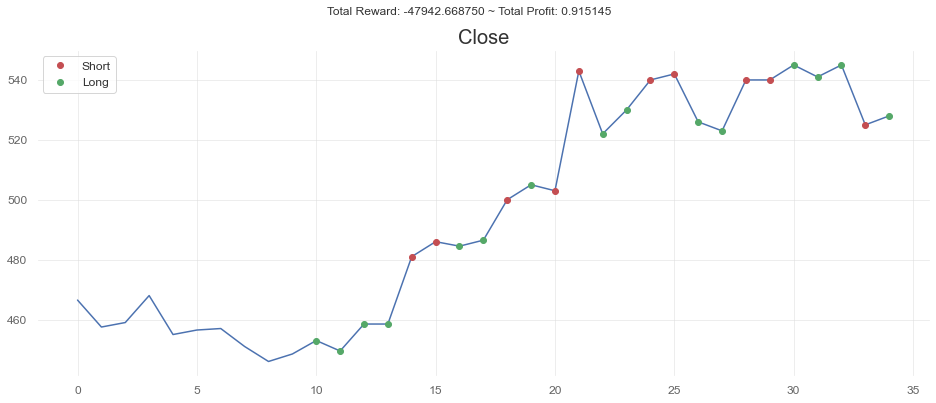

In [46]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


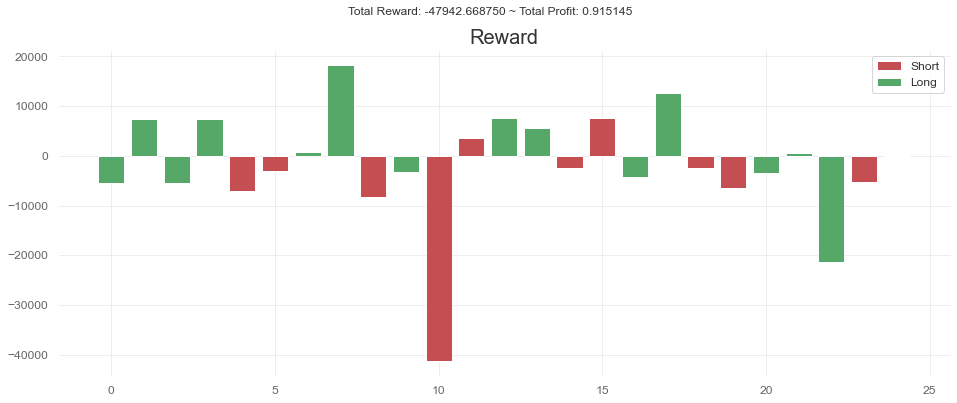

In [47]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


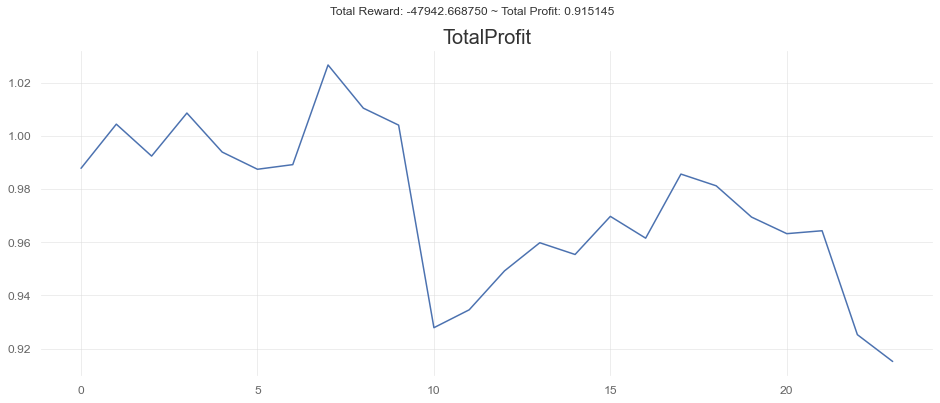

In [48]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)